In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

# 패키지 로드

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

# 데이터 백업

In [10]:
sw_data = pd.read_csv('c:/Users/Admin/AI/downloads/카드소비데이터 수원시/SUWON_S_DATA_TABLE_GENDER_SUM.csv')
sw_data = sw_data[['TA_YMD', 'HOUR', 'DAY', 'DONG', 'CNT', 'UNIT', 'TEMP', 'RAIN', 'AMT']]
sw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101513 entries, 0 to 101512
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   TA_YMD  101513 non-null  int64  
 1   HOUR    101513 non-null  int64  
 2   DAY     101513 non-null  int64  
 3   DONG    101513 non-null  object 
 4   CNT     101513 non-null  int64  
 5   UNIT    101513 non-null  int64  
 6   TEMP    101513 non-null  float64
 7   RAIN    101513 non-null  float64
 8   AMT     101513 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 7.0+ MB


# 상관관계 분석

## 기본

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"  # 한글 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

df = pd.read_csv("data/SUWON_S_DATA_TABLE_GENDER_SUM.csv")

# DAY, HOUR → 범주형으로 처리
df["DAY"] = df["DAY"].astype(str)
df["HOUR"] = df["HOUR"].astype(str)

df_encoded = pd.get_dummies(
    df,
    columns=["DAY", "HOUR"],
    prefix=["DAY", "HOUR"],
    drop_first=False
)

num_df = df_encoded.select_dtypes(include=[np.number])

corr = num_df.corr()

In [19]:
mask = np.triu(np.ones_like(corr, dtype=bool))

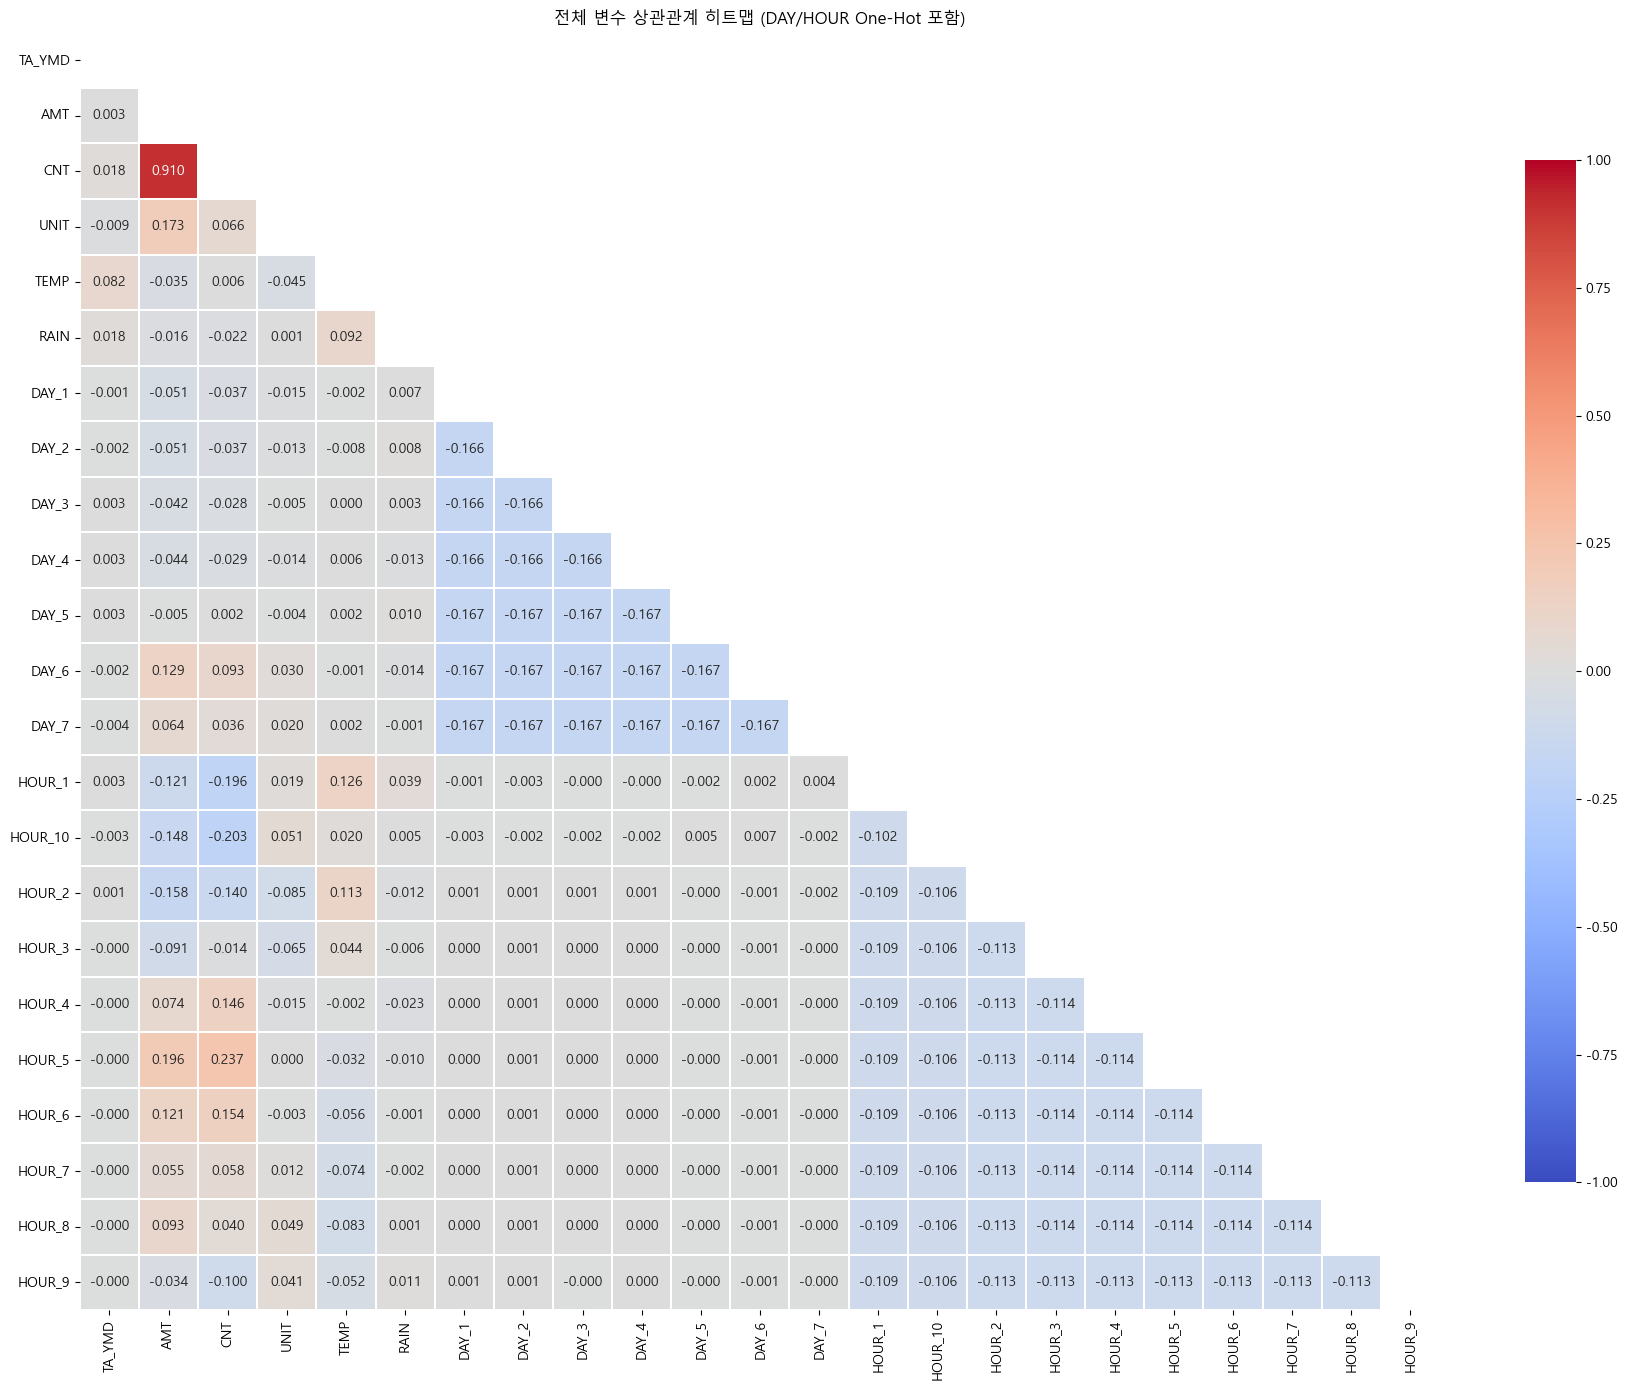

In [14]:
plt.figure(figsize=(18, 14))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.3,
    cbar_kws={"shrink": 0.8},
    annot=True,
    fmt='.3f',
    mask=mask,
    vmax=1,
    vmin=-1
)
plt.title("전체 변수 상관관계 히트맵 (DAY/HOUR One-Hot 포함)")
plt.tight_layout()
plt.show()


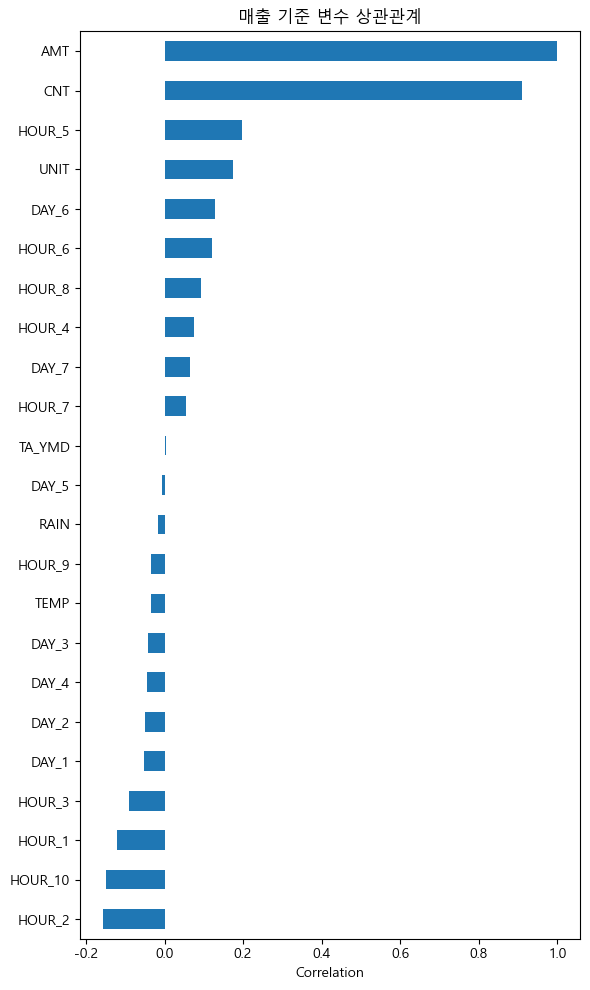

In [11]:
TARGET = "AMT"   

sales_corr = corr[TARGET].sort_values(ascending=False)

plt.figure(figsize=(6, 10))
sales_corr.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("매출 기준 변수 상관관계")
plt.xlabel("Correlation")
plt.tight_layout()
plt.show()


## 배달

In [15]:
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

df = pd.read_csv("data/수원시 팔달구 카페_배달 데이터.csv")

df.head()

,TA_YMD,HOUR,DAY,DONG,AMT,CNT,UNIT,TEMP,RAIN,AMT_D,CNT_D,UNIT_D
0,20230101,1,7,고등동,65063,7,9295,2.10,0.0,0,0,0
1,20230101,2,7,고등동,14878,4,3720,-0.20,0.0,0,0,0
2,20230101,3,7,고등동,77671,20,3884,-2.25,0.0,0,0,0
3,20230101,4,7,고등동,452897,52,8710,-3.20,0.0,0,0,0
4,20230101,5,7,고등동,972179,92,10567,-4.10,0.0,0,0,0


In [24]:
RAIN_COL = "RAIN"       
DELIVERY_COL = "AMT_D"  
OFFLINE_COL = "AMT"  
TEMP_COL = 'TEMP'

corr_df = df[[RAIN_COL, DELIVERY_COL, OFFLINE_COL, TEMP_COL]].corr()
corr_df

,RAIN,AMT_D,AMT,TEMP
RAIN,1.000000,0.005713,-0.016487,0.091750
AMT_D,0.005713,1.000000,0.322754,-0.007277
AMT,-0.016487,0.322754,1.000000,-0.035172
TEMP,0.091750,-0.007277,-0.035172,1.000000


In [25]:
mask = np.triu(np.ones_like(corr_df, dtype=bool))

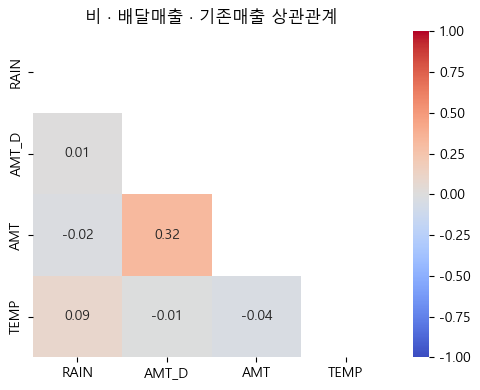

In [26]:
plt.figure(figsize=(5, 4))
sns.heatmap(
    corr_df,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    mask=mask,
    vmax=1,
    vmin=-1
)
plt.title("비 · 기온 · 배달매출 · 기존매출 상관관계")
plt.tight_layout()
plt.show()

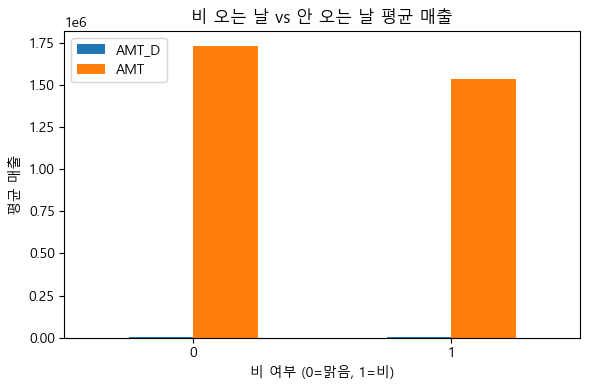

In [27]:
df["is_rain"] = (df[RAIN_COL] > 0).astype(int)

rain_compare = df.groupby("is_rain")[
    [DELIVERY_COL, OFFLINE_COL]
].mean()

rain_compare

rain_compare.plot(
    kind="bar",
    figsize=(6, 4)
)
plt.title("비 오는 날 vs 안 오는 날 평균 매출")
plt.xlabel("비 여부 (0=맑음, 1=비)")
plt.ylabel("평균 매출")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 배달 매출 있는날만 비교

In [28]:
df['has_delivery'] = (df['AMT_D'] > 0).astype(int)

df[["RAIN", "has_delivery"]].corr()


,RAIN,has_delivery
RAIN,1.000000,0.002933
has_delivery,0.002933,1.000000


In [29]:
df_delivery = df[df['AMT_D'] > 0]

df_delivery[['RAIN', 'AMT_D']].corr()


,RAIN,AMT_D
RAIN,1.000000,0.016827
AMT_D,0.016827,1.000000


## 음식 전체 상관관계

In [42]:
df = pd.read_csv("data/SUWON_FOOD_DATA_TABLE.csv")

df["DAY"] = df["DAY"].astype(str)
df["HOUR"] = df["HOUR"].astype(str)

df_encoded = pd.get_dummies(
    df,
    columns=["DAY", "HOUR"],
    prefix=["DAY", "HOUR"],
    drop_first=False
)

SALES_COL = "UNIT"     
RAIN_COL  = "RAIN"      
TEMP_COL  = "TEMP"      
TYPE_COL  = "TYPE"

type_corr = (df.groupby(TYPE_COL)[[RAIN_COL, TEMP_COL, SALES_COL]].corr().unstack().loc[:, (slice(None), SALES_COL)])

type_corr

,RAIN,TEMP,UNIT
,UNIT,UNIT,UNIT
TYPE,,,
간이주점,0.011171,-0.022413,1.0
고기요리,0.001212,-0.041354,1.0
닭/오리요리,0.005003,-0.010530,1.0
별식/퓨전요리,0.004244,-0.031059,1.0
부페,-0.002199,-0.013912,1.0
분식,0.000042,-0.013062,1.0
양식,-0.000289,-0.013237,1.0
유흥주점,0.001153,0.016124,1.0


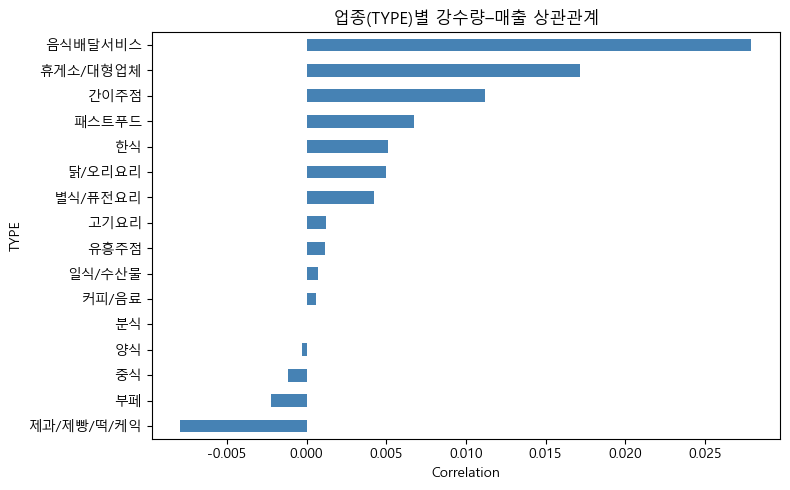

In [40]:
plt.figure(figsize=(8, 5))
type_corr[(RAIN_COL, SALES_COL)].sort_values().plot(
    kind="barh",
    color="steelblue"
)
plt.title("업종(TYPE)별 강수량–매출 상관관계")
plt.xlabel("Correlation")
plt.tight_layout()
plt.show()

In [44]:
corr = df.corr()
corr

C:\Users\Admin\AppData\Local\Temp\ipykernel_13596\2438084875.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,TA_YMD,AMT,CNT,UNIT,TEMP,RAIN
TA_YMD,1.000000,-0.000889,0.013029,-0.001653,0.082817,0.017717
AMT,-0.000889,1.000000,0.824454,0.107276,-0.015337,-0.003241
CNT,0.013029,0.824454,1.000000,-0.004662,-0.005105,-0.007245
UNIT,-0.001653,0.107276,-0.004662,1.000000,-0.017594,0.000986
TEMP,0.082817,-0.015337,-0.005105,-0.017594,1.000000,0.094332
RAIN,0.017717,-0.003241,-0.007245,0.000986,0.094332,1.000000


# 모델 학습

In [8]:
sw_X = sw_data.iloc[:,:-1]
sw_y = sw_data.iloc[:,-1]
sw_X.shape, sw_y.shape

((101513, 8), (101513,))

In [12]:
le = LabelEncoder()

sw_X['DONG_code'] = le.fit_transform(sw_X['DONG'])   # 새 숫자 컬럼
sw_X = sw_X.drop(columns=['DONG'])  

In [13]:
tscv = TimeSeriesSplit(n_splits=5)

for train, test in tscv.split(sw_X):
    X_train, X_test = sw_X.iloc[train], sw_X.iloc[test]
    y_train, y_test = sw_y.iloc[train], sw_y.iloc[test]

    model = XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print("MAE:", mean_absolute_error(y_test, pred))

MAE: 61969.80921891931
MAE: 52584.15421381469
MAE: 41544.993122032734
MAE: 43963.04344594928
MAE: 42599.578318370295


## 가게매출 데이터 생성

In [25]:
import pandas as pd
import numpy as np

# ---------------------------
# 더미 가게 매출 데이터 생성
# ---------------------------
np.random.seed(42)

# 최근 60일 (사장님이 입력했다고 가정)
dates = pd.date_range("2025-08-01", "2025-12-24", freq="D")

# 가게 일매출 (임의 생성, 현실적인 범위)
# 평일 낮고 / 주말 조금 높게
sales = []
for d in dates:
    base = 120_000
    if d.weekday() >= 5:  # 주말
        base *= 1.2
    noise = np.random.normal(0, 20_000)
    sales.append(max(20_000, base + noise))

store_df = pd.DataFrame({
    "ta_ymd": dates.strftime("%Y%m%d").astype(int),
    "store_amt": sales
})

# 저장 경로 
out_path = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/store_sales.csv"
store_df.to_csv(out_path, index=False, encoding="utf-8-sig")

print(f"store_sales.csv 생성 완료 -> {out_path}")
print(store_df.head())


store_sales.csv 생성 완료 -> c:/Users/Admin/AI/downloads/카드소비데이터 수원시/store_sales.csv
     ta_ymd      store_amt
0  20250801  129934.283060
1  20250802  141234.713977
2  20250803  156953.770762
3  20250804  150460.597128
4  20250805  115316.932506


## GPT1-1

In [22]:
# -*- coding: utf-8 -*-
"""
Option 2 (추천)
- 모델 피처: temp + rain_mean + rain_max + 파생(temp_clip, log) + calendar + holiday + lag/rolling
- 고객 출력: rain_max(피크) 중심으로 안내
- A 검증: 데이터 범위 내(<= daily_max_ymd)면 데이터에서 날씨 사용
- B 운영 준비: 데이터 범위 밖이면 getVilageFcst로 temp/rain_mean/rain_max 생성(준비만)
"""

import os
import re
import numpy as np
import pandas as pd
import requests
import joblib
from dataclasses import dataclass
from sklearn.metrics import mean_absolute_error
from dotenv import load_dotenv
load_dotenv()

# =========================
# Config
# =========================
@dataclass
class Config:
    dong_data_path: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/SUWON_S_DATA_TABLE_GENDER_SUM.csv"
    store_sales_path: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/store_sales.csv"

    model_out_dir: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models"
    model_name: str = "suwon_daily_amt_meanmax.pkl"

    train_end: int = 20241231
    test_start: int = 20250101

    lags: tuple = (1, 7, 14, 28)
    rolling_windows: tuple = (7, 14, 28)

    use_log_target: bool = True

    share_window_days: int = 56
    min_overlap_days: int = 7

    # simple adjustment
    adj_weekend: float = 1.05
    adj_holiday: float = 1.08
    adj_rain: float = 0.93

    # KMA key env name
    service_key_env: str = "RAIN_ID"

CFG = Config()

# (예보용) nx, ny 매핑 (일단 동일)
DONG_TO_GRID = {k: (61, 121) for k in ["고등동","인계동","행궁동","매산동","매교동","우만1동","우만2동","지동","화서1동","화서2동"]}


# =========================
# Metrics
# =========================
def wmape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.sum(np.abs(y_true)), eps)
    return float(np.sum(np.abs(y_true - y_pred)) / denom * 100.0)


# =========================
# Holidays (2023-01-01 ~ 2025-10-31)
# =========================
def holiday_set_2023_2025_upto_oct31() -> set[pd.Timestamp]:
    dates = []
    dates += ["2023-01-01","2023-01-21","2023-01-22","2023-01-23","2023-01-24","2023-03-01",
              "2023-05-05","2023-05-27","2023-05-29","2023-06-06","2023-08-15","2023-09-28",
              "2023-09-29","2023-09-30","2023-10-03","2023-10-09","2023-12-25"]
    dates += ["2024-01-01","2024-02-09","2024-02-10","2024-02-11","2024-02-12","2024-03-01",
              "2024-05-05","2024-05-06","2024-05-15","2024-06-06","2024-08-15","2024-09-16",
              "2024-09-17","2024-09-18","2024-10-03","2024-10-09","2024-12-25"]
    dates += ["2025-01-01","2025-01-28","2025-01-29","2025-01-30","2025-03-01","2025-03-03",
              "2025-05-05","2025-05-06","2025-06-06","2025-08-15",
              "2025-10-03","2025-10-05","2025-10-06","2025-10-07","2025-10-08","2025-10-09"]
    s = set(pd.to_datetime(dates))
    start, end = pd.Timestamp("2023-01-01"), pd.Timestamp("2025-10-31")
    return {d for d in s if start <= d <= end}

HOLIDAYS = holiday_set_2023_2025_upto_oct31()


# =========================
# Helpers
# =========================
def ymd_int_to_ts(ymd: int) -> pd.Timestamp:
    return pd.to_datetime(str(int(ymd)), format="%Y%m%d")

def make_calendar_features(date: pd.Timestamp) -> dict:
    # 0~6 체계로 고정 (중복/혼선 방지)
    dow = int(date.dayofweek)  # 0=Mon ... 6=Sun
    is_weekend = int(dow in [5, 6])
    m = date.month
    return {
        "dow": dow,
        "is_weekend": is_weekend,
        "year": date.year,
        "month": m,
        "day": date.day,
        "weekofyear": int(date.isocalendar().week),
        "month_sin": float(np.sin(2*np.pi*m/12.0)),
        "month_cos": float(np.cos(2*np.pi*m/12.0)),
        "dow_sin": float(np.sin(2*np.pi*dow/7.0)),
        "dow_cos": float(np.cos(2*np.pi*dow/7.0)),
    }

def make_holiday_features(date: pd.Timestamp) -> dict:
    is_h = int(date in HOLIDAYS)
    is_before = int((date + pd.Timedelta(days=1)) in HOLIDAYS)
    is_after  = int((date - pd.Timedelta(days=1)) in HOLIDAYS)
    around = int(any((date + pd.Timedelta(days=k)) in HOLIDAYS for k in [-2,-1,0,1,2]))
    return {
        "is_holiday": is_h,
        "is_before_holiday": is_before,
        "is_after_holiday": is_after,
        "is_around_holiday_2d": around
    }

def make_weather_derived_features(temp: float, rain_mean: float, rain_max: float) -> dict:
    """원본 temp/rain_mean/rain_max는 daily에 이미 있으므로 여기서는 '파생'만 만든다."""
    temp = float(temp)
    rain_mean = max(0.0, float(rain_mean))
    rain_max = max(0.0, float(rain_max))
    return {
        "temp_clip": float(np.clip(temp, -20, 45)),
        "is_rain": int(max(rain_mean, rain_max) > 0),
        "rain_mean_log1p": float(np.log1p(rain_mean)),
        "rain_max_log1p": float(np.log1p(rain_max)),
    }

def adjust_factor(is_weekend: bool, is_holiday: bool, is_rain: bool, cfg: Config) -> float:
    adj = 1.0
    if is_weekend: adj *= cfg.adj_weekend
    if is_holiday: adj *= cfg.adj_holiday
    if is_rain:    adj *= cfg.adj_rain
    return float(adj)


# =========================
# 1) Load raw + daily aggregation
# =========================
def load_raw(cfg: Config) -> pd.DataFrame:
    df = pd.read_csv(cfg.dong_data_path)
    rename_map = {
        "TA_YMD": "ta_ymd",
        "HOUR": "hour",
        "DAY": "dow_raw",
        "DONG": "dong",
        "AMT": "amt",
        "CNT": "cnt",
        "UNIT": "unit",
        "TEMP": "temp",
        "RAIN": "rain",
    }
    df = df.rename(columns=rename_map)

    needed = {"ta_ymd","hour","dong","amt","cnt","unit","temp","rain"}
    miss = needed - set(df.columns)
    if miss:
        raise ValueError(f"Missing columns: {miss}")

    df["ta_ymd"] = pd.to_numeric(df["ta_ymd"], errors="raise").astype(int)
    df["date"] = pd.to_datetime(df["ta_ymd"].astype(str), format="%Y%m%d", errors="raise")
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce").astype(int)
    df["dong"] = df["dong"].astype(str)

    for c in ["amt","cnt","unit","temp","rain"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    return df.sort_values(["dong","date","hour"]).reset_index(drop=True)

def make_daily(df: pd.DataFrame) -> pd.DataFrame:
    """
    - amt: 일합
    - cnt: 일합
    - temp: 일평균
    - rain: 시간대 평균 강수량(네 정의) -> 일평균(rain_mean), 일최대(rain_max)
    """
    daily = df.groupby(["dong","ta_ymd","date"], as_index=False).agg(
        amt=("amt","sum"),
        cnt=("cnt","sum"),
        temp=("temp","mean"),
        rain_mean=("rain","mean"),
        rain_max=("rain","max"),
    )
    daily["unit"] = (daily["amt"] / daily["cnt"].replace(0, np.nan)).fillna(0)
    return daily.sort_values(["dong","ta_ymd"]).reset_index(drop=True)


# =========================
# 2) lag/rolling
# =========================
def add_lag_rolling(daily: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    g = daily.groupby("dong", sort=False)

    for lag in cfg.lags:
        daily[f"amt_lag_{lag}"] = g["amt"].shift(lag)
        daily[f"cnt_lag_{lag}"] = g["cnt"].shift(lag)
        daily[f"unit_lag_{lag}"] = g["unit"].shift(lag)

    for w in cfg.rolling_windows:
        minp = max(3, w//3)
        daily[f"amt_roll_{w}_mean"] = g["amt"].shift(1).rolling(w, min_periods=minp).mean()
        daily[f"amt_roll_{w}_std"]  = g["amt"].shift(1).rolling(w, min_periods=minp).std()

    return daily


# =========================
# 3) dataset build (✅ 중복 컬럼 완전 방지)
# =========================
def build_dataset(daily: pd.DataFrame, cfg: Config):
    cal_df = pd.DataFrame(list(daily["date"].apply(make_calendar_features)))
    hol_df = pd.DataFrame(list(daily["date"].apply(make_holiday_features)))
    wea_df = pd.DataFrame(list(daily.apply(lambda r: make_weather_derived_features(r["temp"], r["rain_mean"], r["rain_max"]), axis=1)))

    out = pd.concat([daily.reset_index(drop=True), cal_df, hol_df, wea_df], axis=1)

    out = add_lag_rolling(out, cfg)

    # ✅ 중복 컬럼 검사 (문제 있으면 여기서 바로 알림)
    dup = out.columns[out.columns.duplicated()].tolist()
    if dup:
        raise ValueError(f"Duplicate columns detected: {dup}")

    feature_cols = [
        "dong",
        # calendar
        "dow","is_weekend","year","month","day","weekofyear",
        "month_sin","month_cos","dow_sin","dow_cos",
        # raw weather
        "temp",
        "rain_mean","rain_max",
        # derived weather
        "temp_clip","is_rain","rain_mean_log1p","rain_max_log1p",
        # holiday
        "is_holiday","is_before_holiday","is_after_holiday","is_around_holiday_2d",
    ]
    for lag in cfg.lags:
        feature_cols += [f"amt_lag_{lag}", f"cnt_lag_{lag}", f"unit_lag_{lag}"]
    for w in cfg.rolling_windows:
        feature_cols += [f"amt_roll_{w}_mean", f"amt_roll_{w}_std"]

    data = out.dropna(subset=feature_cols + ["amt"]).copy()

    if cfg.use_log_target:
        data["target"] = np.log1p(data["amt"])
    else:
        data["target"] = data["amt"]

    return data, feature_cols


# =========================
# 4) train (LightGBM)
# =========================
def train_and_eval(data: pd.DataFrame, feature_cols, cfg: Config):
    train = data[data["ta_ymd"] <= cfg.train_end].copy()
    test  = data[data["ta_ymd"] >= cfg.test_start].copy()

    if train.empty or test.empty:
        raise ValueError("train/test split empty. 날짜 범위 확인")

    # time-aware validation split
    tr_sorted = train.sort_values("ta_ymd")
    split = int(len(tr_sorted) * 0.8)
    tr_idx = tr_sorted.index[:split]
    va_idx = tr_sorted.index[split:]

    X_train = train.loc[tr_idx, feature_cols].copy()
    y_train = train.loc[tr_idx, "target"].values
    X_valid = train.loc[va_idx, feature_cols].copy()
    y_valid = train.loc[va_idx, "target"].values

    X_test = test[feature_cols].copy()
    y_test = test["target"].values

    # categorical
    X_train["dong"] = X_train["dong"].astype("category")
    X_valid["dong"] = X_valid["dong"].astype("category")
    X_test["dong"] = X_test["dong"].astype("category")

    import lightgbm as lgb

    model = lgb.LGBMRegressor(
        n_estimators=5000,
        learning_rate=0.02,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric="l1",
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )

    pred = model.predict(X_test)

    if cfg.use_log_target:
        y_true = np.expm1(y_test)
        y_pred = np.expm1(pred)
    else:
        y_true = y_test
        y_pred = pred

    mae = mean_absolute_error(y_true, y_pred)
    w = wmape(y_true, y_pred)

    print("[Model] LightGBM (rain_mean + rain_max)")
    print(f"[Test] MAE   : {mae:,.0f}")
    print(f"[Test] WMAPE : {w:.2f}%")

    os.makedirs(cfg.model_out_dir, exist_ok=True)
    out_path = os.path.join(cfg.model_out_dir, cfg.model_name)
    joblib.dump({"model": model, "feature_cols": feature_cols, "cfg": cfg}, out_path)
    print(f"Saved -> {out_path}")

    return out_path


# =========================
# 5) (B 준비) forecast weather (VilageFcst)
# =========================
def _get_service_key(cfg: Config) -> str:
    k = os.getenv(cfg.service_key_env)
    if not k:
        raise ValueError(f"환경변수 {cfg.service_key_env}가 없습니다. .env에 {cfg.service_key_env}=... 넣어주세요.")
    return k

def _pick_base_datetime_kst():
    now = pd.Timestamp.now(tz="Asia/Seoul")
    base_times = ["2300","2000","1700","1400","1100","0800","0500","0200"]
    for bt in base_times:
        cand = pd.Timestamp(f"{now.strftime('%Y-%m-%d')} {bt[:2]}:{bt[2:]}", tz="Asia/Seoul")
        if now >= cand + pd.Timedelta(minutes=40):
            return now.strftime("%Y%m%d"), bt
    yday = (now - pd.Timedelta(days=1)).strftime("%Y%m%d")
    return yday, "2300"

def _parse_pcp(v: str) -> float:
    if v is None: return 0.0
    v = str(v).strip()
    if v == "" or "강수없음" in v: return 0.0
    if "미만" in v: return 0.5
    if "~" in v: v = v.split("~")[0]
    m = re.findall(r"[-+]?\d*\.?\d+", v)
    return float(m[0]) if m else 0.0

def get_forecast_weather(dong: str, target_ymd: int, cfg: Config):
    sk = _get_service_key(cfg)
    base_date, base_time = _pick_base_datetime_kst()

    if dong not in DONG_TO_GRID:
        raise ValueError(f"동 nx/ny 매핑 없음: {dong}")

    nx, ny = DONG_TO_GRID[dong]
    url = "https://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"
    full_url = f"{url}?serviceKey={sk}"

    params = {
        "pageNo": 1,
        "numOfRows": 2000,
        "dataType": "JSON",
        "base_date": base_date,
        "base_time": base_time,
        "nx": int(nx),
        "ny": int(ny),
    }

    r = requests.get(full_url, params=params, timeout=15)
    r.raise_for_status()
    data = r.json()

    header = data["response"]["header"]
    if header.get("resultCode") != "00":
        raise ValueError(f"KMA Vilage error: {header.get('resultMsg')} (code={header.get('resultCode')})")

    items = data["response"]["body"]["items"]["item"]

    temps, pcps = [], []
    for it in items:
        if it.get("fcstDate") != str(target_ymd):
            continue
        if it.get("category") == "TMP":
            temps.append(float(it.get("fcstValue")))
        elif it.get("category") == "PCP":
            pcps.append(_parse_pcp(it.get("fcstValue")))

    if not temps:
        raise ValueError(f"예보(TMP) 없음: target={target_ymd} base={base_date}{base_time}")

    temp = float(np.mean(temps))
    rain_mean = float(np.mean(pcps)) if pcps else 0.0
    rain_max = float(np.max(pcps)) if pcps else 0.0
    return temp, rain_mean, rain_max


# =========================
# 6) store share + inference + customer demo
# =========================
def load_store_sales(path: str) -> pd.DataFrame:
    s = pd.read_csv(path)
    if "ta_ymd" not in s.columns or "store_amt" not in s.columns:
        raise ValueError("store_sales.csv needs columns: ta_ymd, store_amt")
    s["ta_ymd"] = pd.to_numeric(s["ta_ymd"], errors="coerce").astype(int)
    s["date"] = pd.to_datetime(s["ta_ymd"].astype(str), format="%Y%m%d", errors="raise")
    s["store_amt"] = pd.to_numeric(s["store_amt"], errors="coerce")
    return s.dropna(subset=["store_amt"]).sort_values("ta_ymd").reset_index(drop=True)

def compute_share(daily: pd.DataFrame, store: pd.DataFrame, dong: str, target_ymd: int, cfg: Config) -> float:
    end_date = ymd_int_to_ts(target_ymd) - pd.Timedelta(days=1)
    start_date = end_date - pd.Timedelta(days=cfg.share_window_days)

    dong_hist = daily[(daily["dong"]==dong) & (daily["date"]>=start_date) & (daily["date"]<=end_date)][["date","amt"]]
    store_hist = store[(store["date"]>=start_date) & (store["date"]<=end_date)][["date","store_amt"]]
    merged = dong_hist.merge(store_hist, on="date", how="inner")

    if len(merged) < cfg.min_overlap_days:
        return 0.0

    denom = merged["amt"].sum()
    if denom <= 0:
        return 0.0

    share = float(merged["store_amt"].sum() / denom)
    return float(np.clip(share, 0.0, 0.2))

def build_one_row_for_predict(daily: pd.DataFrame, dong: str, target_ymd: int,
                              temp: float, rain_mean: float, rain_max: float, cfg: Config,
                              feature_cols: list) -> pd.DataFrame:
    # dong별 과거
    h = daily[daily["dong"]==dong].copy().sort_values("ta_ymd")

    target_date = ymd_int_to_ts(target_ymd)
    cal = make_calendar_features(target_date)
    hol = make_holiday_features(target_date)
    wea_der = make_weather_derived_features(temp, rain_mean, rain_max)

    # target row 추가
    row = {
        "dong": dong,
        "ta_ymd": int(target_ymd),
        "date": target_date,
        "amt": np.nan,
        "cnt": np.nan,
        "unit": np.nan,
        "temp": float(temp),
        "rain_mean": float(rain_mean),
        "rain_max": float(rain_max),
    }
    tmp = pd.concat([h, pd.DataFrame([row])], ignore_index=True).sort_values("ta_ymd").reset_index(drop=True)

    # lag/rolling
    g = tmp.groupby("dong", sort=False)
    for lag in cfg.lags:
        tmp[f"amt_lag_{lag}"] = g["amt"].shift(lag)
        tmp[f"cnt_lag_{lag}"] = g["cnt"].shift(lag)
        tmp[f"unit_lag_{lag}"] = g["unit"].shift(lag)

    for w in cfg.rolling_windows:
        minp = max(3, w//3)
        tmp[f"amt_roll_{w}_mean"] = g["amt"].shift(1).rolling(w, min_periods=minp).mean()
        tmp[f"amt_roll_{w}_std"]  = g["amt"].shift(1).rolling(w, min_periods=minp).std()

    last = tmp.iloc[[-1]].copy()
    # attach derived features
    for k,v in cal.items(): last[k] = v
    for k,v in hol.items(): last[k] = v
    for k,v in wea_der.items(): last[k] = v

    # final duplicate check
    dup = last.columns[last.columns.duplicated()].tolist()
    if dup:
        raise ValueError(f"Duplicate columns in inference row: {dup}")

    return last[feature_cols].copy()

def predict_customer_sales(dong: str, target_ymd: int, model_pack_path: str, cfg: Config):
    pack = joblib.load(model_pack_path)
    model = pack["model"]
    feature_cols = pack["feature_cols"]

    raw = load_raw(cfg)
    daily = make_daily(raw)
    daily_max_ymd = int(daily["ta_ymd"].max())

    # A 검증: 데이터 날씨 사용 / B 운영 준비: 예보 사용
    if target_ymd <= daily_max_ymd:
        row = daily[(daily["dong"]==dong) & (daily["ta_ymd"]==int(target_ymd))]
        if row.empty:
            raise ValueError(f"daily에 해당 dong/date 없음: {dong}, {target_ymd}")
        temp = float(row["temp"].iloc[0])
        rain_mean = float(row["rain_mean"].iloc[0])
        rain_max = float(row["rain_max"].iloc[0])
        weather_src = "DATA_WEATHER(A 검증)"
    else:
        temp, rain_mean, rain_max = get_forecast_weather(dong, target_ymd, cfg)
        weather_src = "KMA_FORECAST(B 운영)"

    # 동 예측
    X = build_one_row_for_predict(daily, dong, target_ymd, temp, rain_mean, rain_max, cfg, feature_cols)
    X["dong"] = X["dong"].astype("category")

    pred = model.predict(X)[0]
    dong_pred = float(np.expm1(pred) if cfg.use_log_target else pred)
    dong_pred = max(0.0, dong_pred)

    # store share + adjustment (가능하면)
    store_pred = None
    share = None
    adj = None
    try:
        store = load_store_sales(cfg.store_sales_path)
        share = compute_share(daily, store, dong, target_ymd, cfg)

        date_ts = ymd_int_to_ts(target_ymd)
        cal = make_calendar_features(date_ts)
        hol = make_holiday_features(date_ts)
        adj = adjust_factor(bool(cal["is_weekend"]), bool(hol["is_holiday"]), bool(rain_max>0 or rain_mean>0), cfg)
        store_pred = max(0.0, dong_pred * share * adj)
    except Exception:
        pass

    # 고객 메시지 (rain_max 중심)
    lines = []
    lines.append(f"📍지역(동): {dong}")
    lines.append(f"📅날짜: {target_ymd}")
    lines.append(f"🌦️날씨(출처): {weather_src}")
    lines.append(f"   - 평균기온(일평균): {temp:.1f}°C")
    lines.append(f"   - 시간대 평균 강수량(일평균): {rain_mean:.2f} mm")
    lines.append(f"   - ✅시간대 평균 강수량(일최대, 피크): {rain_max:.2f} mm  ← 고객에게 보여줄 핵심")
    lines.append(f"💰예상 동 전체 일매출: {dong_pred:,.0f} 원")

    if store_pred is None:
        lines.append("🏪가게 예측: store_sales.csv가 없거나 형식 오류 → 동 예측만 제공")
    else:
        lines.append(f"🏪가게 점유율(최근 {cfg.share_window_days}일): {share*100:.3f}%")
        lines.append(f"🏪보정계수(adj): {adj:.3f}")
        lines.append(f"🏪예상 가게 일매출: {store_pred:,.0f} 원")

    return {
        "dong": dong,
        "date": int(target_ymd),
        "temp": round(temp, 1),
        "rain_mean": round(rain_mean, 2),
        "rain_max": round(rain_max, 2),
        "dong_pred": int(dong_pred),
        "share_pct": None if share is None else round(share*100, 3),
        "store_pred": None if store_pred is None else int(store_pred),
        "customer_message": "\n".join(lines),
    }


# =========================
# MAIN: train + customer demo
# =========================
def main():
    raw = load_raw(CFG)
    daily = make_daily(raw)
    data, feature_cols = build_dataset(daily, CFG)

    model_path = train_and_eval(data, feature_cols, CFG)

    # ===== 고객 입력 시나리오 =====
    customer_dong = "고등동"
    customer_date = int(daily["ta_ymd"].max())  # 예: 20251031 (A 검증)

    result = predict_customer_sales(customer_dong, customer_date, model_path, CFG)

    print("\n" + "="*60)
    print("✅ [고객 화면 출력 예시]")
    print("="*60)
    print(result["customer_message"])
    print("="*60)
    print("\n[RAW RESULT]")
    print(result)

if __name__ == "__main__":
    main()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5664
[LightGBM] [Info] Number of data points in the train set: 5624, number of used features: 40
[LightGBM] [Info] Start training from score 16.047767
[Model] LightGBM (rain_mean + rain_max)
[Test] MAE   : 2,157,716
[Test] WMAPE : 12.73%
Saved -> c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models\suwon_daily_amt_meanmax.pkl

✅ [고객 화면 출력 예시]
📍지역(동): 고등동
📅날짜: 20251031
🌦️날씨(출처): DATA_WEATHER(A 검증)
   - 평균기온(일평균): 13.6°C
   - 시간대 평균 강수량(일평균): 0.19 mm
   - ✅시간대 평균 강수량(일최대, 피크): 1.50 mm  ← 고객에게 보여줄 핵심
💰예상 동 전체 일매출: 3,082,178 원
🏪가게 점유율(최근 56일): 4.605%
🏪보정계수(adj): 0.930
🏪예상 가게 일매출: 131,986 원

[RAW RESULT]
{'dong': '고등동', 'date': 20251031, 'temp': 13.6, 'rain_mean': 0.19, 'rain_max': 1.5, 'dong_pred': 3082177, 'share_pct': 4.605, 'store_pred': 131986, 'customer_message': '📍지역(동): 고등동\n📅날짜: 20251031\n🌦️날씨(출처): D

### 예측

In [26]:
MODEL_PATH = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models/suwon_daily_amt_meanmax.pkl"

# 고객 입력 
result = predict_customer_sales(
    dong="행궁동",
    target_ymd=20251224,
    model_pack_path=MODEL_PATH,
    cfg=CFG
)

print(result["customer_message"])   # 고객에게 보여줄 문장
print(result["store_pred"])         # (가능하면) 가게 예상매출 숫자

📍지역(동): 행궁동
📅날짜: 20251224
🌦️날씨(출처): KMA_FORECAST(B 운영)
   - 평균기온(일평균): 0.7°C
   - 시간대 평균 강수량(일평균): 0.00 mm
   - ✅시간대 평균 강수량(일최대, 피크): 0.00 mm  ← 고객에게 보여줄 핵심
💰예상 동 전체 일매출: 59,040,949 원
🏪가게 점유율(최근 56일): 0.000%
🏪보정계수(adj): 1.000
🏪예상 가게 일매출: 0 원
0


## GPT1-2

In [27]:
"""
Option 2 (추천)
- 모델 피처: temp + rain_mean + rain_max + 파생(temp_clip, log) + calendar + holiday + lag/rolling
- 고객 출력: rain_max(피크) 중심으로 안내
- A 검증: 데이터 범위 내(<= daily_max_ymd)면 데이터에서 날씨 사용
- B 운영 준비: 데이터 범위 밖이면 getVilageFcst로 temp/rain_mean/rain_max 생성(준비만)
"""

import os
import re
import numpy as np
import pandas as pd
import requests
import joblib
from dataclasses import dataclass
from sklearn.metrics import mean_absolute_error
from dotenv import load_dotenv
load_dotenv()

# =========================
# Config
# =========================
@dataclass
class Config:
    dong_data_path: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/SUWON_S_DATA_TABLE_GENDER_SUM.csv"
    store_sales_path: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/store_sales.csv"

    model_out_dir: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models"
    model_name: str = "suwon_daily_amt_meanmax.pkl"

    train_end: int = 20241231
    test_start: int = 20250101

    lags: tuple = (1, 7, 14, 28)
    rolling_windows: tuple = (7, 14, 28)

    use_log_target: bool = True

    share_window_days: int = 56
    min_overlap_days: int = 7

    # simple adjustment
    adj_weekend: float = 1.05
    adj_holiday: float = 1.08
    adj_rain: float = 0.93

    # KMA key env name
    service_key_env: str = "RAIN_ID"

CFG = Config()

# (예보용) nx, ny 매핑 (일단 동일)
DONG_TO_GRID = {k: (61, 121) for k in ["고등동","인계동","행궁동","매산동","매교동","우만1동","우만2동","지동","화서1동","화서2동"]}


# =========================
# Metrics
# =========================
def wmape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.sum(np.abs(y_true)), eps)
    return float(np.sum(np.abs(y_true - y_pred)) / denom * 100.0)


# =========================
# Holidays (2023-01-01 ~ 2025-10-31)
# =========================
def holiday_set_2023_2025_upto_oct31() -> set[pd.Timestamp]:
    dates = []
    dates += ["2023-01-01","2023-01-21","2023-01-22","2023-01-23","2023-01-24","2023-03-01",
              "2023-05-05","2023-05-27","2023-05-29","2023-06-06","2023-08-15","2023-09-28",
              "2023-09-29","2023-09-30","2023-10-03","2023-10-09","2023-12-25"]
    dates += ["2024-01-01","2024-02-09","2024-02-10","2024-02-11","2024-02-12","2024-03-01",
              "2024-05-05","2024-05-06","2024-05-15","2024-06-06","2024-08-15","2024-09-16",
              "2024-09-17","2024-09-18","2024-10-03","2024-10-09","2024-12-25"]
    dates += ["2025-01-01","2025-01-28","2025-01-29","2025-01-30","2025-03-01","2025-03-03",
              "2025-05-05","2025-05-06","2025-06-06","2025-08-15",
              "2025-10-03","2025-10-05","2025-10-06","2025-10-07","2025-10-08","2025-10-09"]
    s = set(pd.to_datetime(dates))
    start, end = pd.Timestamp("2023-01-01"), pd.Timestamp("2025-10-31")
    return {d for d in s if start <= d <= end}

HOLIDAYS = holiday_set_2023_2025_upto_oct31()


# =========================
# Helpers
# =========================
def ymd_int_to_ts(ymd: int) -> pd.Timestamp:
    return pd.to_datetime(str(int(ymd)), format="%Y%m%d")

def make_calendar_features(date: pd.Timestamp) -> dict:
    # 0~6 체계로 고정 (중복/혼선 방지)
    dow = int(date.dayofweek)  # 0=Mon ... 6=Sun
    is_weekend = int(dow in [5, 6])
    m = date.month
    return {
        "dow": dow,
        "is_weekend": is_weekend,
        "year": date.year,
        "month": m,
        "day": date.day,
        "weekofyear": int(date.isocalendar().week),
        "month_sin": float(np.sin(2*np.pi*m/12.0)),
        "month_cos": float(np.cos(2*np.pi*m/12.0)),
        "dow_sin": float(np.sin(2*np.pi*dow/7.0)),
        "dow_cos": float(np.cos(2*np.pi*dow/7.0)),
    }

def make_holiday_features(date: pd.Timestamp) -> dict:
    is_h = int(date in HOLIDAYS)
    is_before = int((date + pd.Timedelta(days=1)) in HOLIDAYS)
    is_after  = int((date - pd.Timedelta(days=1)) in HOLIDAYS)
    around = int(any((date + pd.Timedelta(days=k)) in HOLIDAYS for k in [-2,-1,0,1,2]))
    return {
        "is_holiday": is_h,
        "is_before_holiday": is_before,
        "is_after_holiday": is_after,
        "is_around_holiday_2d": around
    }

def make_weather_derived_features(temp: float, rain_mean: float, rain_max: float) -> dict:
    """원본 temp/rain_mean/rain_max는 daily에 이미 있으므로 여기서는 '파생'만 만든다."""
    temp = float(temp)
    rain_mean = max(0.0, float(rain_mean))
    rain_max = max(0.0, float(rain_max))
    return {
        "temp_clip": float(np.clip(temp, -20, 45)),
        "is_rain": int(max(rain_mean, rain_max) > 0),
        "rain_mean_log1p": float(np.log1p(rain_mean)),
        "rain_max_log1p": float(np.log1p(rain_max)),
    }

def adjust_factor(is_weekend: bool, is_holiday: bool, is_rain: bool, cfg: Config) -> float:
    adj = 1.0
    if is_weekend: adj *= cfg.adj_weekend
    if is_holiday: adj *= cfg.adj_holiday
    if is_rain:    adj *= cfg.adj_rain
    return float(adj)


# =========================
# 1) Load raw + daily aggregation
# =========================
def load_raw(cfg: Config) -> pd.DataFrame:
    df = pd.read_csv(cfg.dong_data_path)
    rename_map = {
        "TA_YMD": "ta_ymd",
        "HOUR": "hour",
        "DAY": "dow_raw",
        "DONG": "dong",
        "AMT": "amt",
        "CNT": "cnt",
        "UNIT": "unit",
        "TEMP": "temp",
        "RAIN": "rain",
    }
    df = df.rename(columns=rename_map)

    needed = {"ta_ymd","hour","dong","amt","cnt","unit","temp","rain"}
    miss = needed - set(df.columns)
    if miss:
        raise ValueError(f"Missing columns: {miss}")

    df["ta_ymd"] = pd.to_numeric(df["ta_ymd"], errors="raise").astype(int)
    df["date"] = pd.to_datetime(df["ta_ymd"].astype(str), format="%Y%m%d", errors="raise")
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce").astype(int)
    df["dong"] = df["dong"].astype(str)

    for c in ["amt","cnt","unit","temp","rain"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    return df.sort_values(["dong","date","hour"]).reset_index(drop=True)

def make_daily(df: pd.DataFrame) -> pd.DataFrame:
    """
    - amt: 일합
    - cnt: 일합
    - temp: 일평균
    - rain: 시간대 평균 강수량(네 정의) -> 일평균(rain_mean), 일최대(rain_max)
    """
    daily = df.groupby(["dong","ta_ymd","date"], as_index=False).agg(
        amt=("amt","sum"),
        cnt=("cnt","sum"),
        temp=("temp","mean"),
        rain_mean=("rain","mean"),
        rain_max=("rain","max"),
    )
    daily["unit"] = (daily["amt"] / daily["cnt"].replace(0, np.nan)).fillna(0)
    return daily.sort_values(["dong","ta_ymd"]).reset_index(drop=True)


# =========================
# 2) lag/rolling
# =========================
def add_lag_rolling(daily: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    g = daily.groupby("dong", sort=False)

    for lag in cfg.lags:
        daily[f"amt_lag_{lag}"] = g["amt"].shift(lag)
        daily[f"cnt_lag_{lag}"] = g["cnt"].shift(lag)
        daily[f"unit_lag_{lag}"] = g["unit"].shift(lag)

    for w in cfg.rolling_windows:
        minp = max(3, w//3)
        daily[f"amt_roll_{w}_mean"] = g["amt"].shift(1).rolling(w, min_periods=minp).mean()
        daily[f"amt_roll_{w}_std"]  = g["amt"].shift(1).rolling(w, min_periods=minp).std()

    return daily


# =========================
# 3) dataset build (✅ 중복 컬럼 완전 방지)
# =========================
def build_dataset(daily: pd.DataFrame, cfg: Config):
    cal_df = pd.DataFrame(list(daily["date"].apply(make_calendar_features)))
    hol_df = pd.DataFrame(list(daily["date"].apply(make_holiday_features)))
    wea_df = pd.DataFrame(list(daily.apply(lambda r: make_weather_derived_features(r["temp"], r["rain_mean"], r["rain_max"]), axis=1)))

    out = pd.concat([daily.reset_index(drop=True), cal_df, hol_df, wea_df], axis=1)

    out = add_lag_rolling(out, cfg)

    # ✅ 중복 컬럼 검사 (문제 있으면 여기서 바로 알림)
    dup = out.columns[out.columns.duplicated()].tolist()
    if dup:
        raise ValueError(f"Duplicate columns detected: {dup}")

    feature_cols = [
        "dong",
        # calendar
        "dow","is_weekend","year","month","day","weekofyear",
        "month_sin","month_cos","dow_sin","dow_cos",
        # raw weather
        "temp",
        "rain_mean","rain_max",
        # derived weather
        "temp_clip","is_rain","rain_mean_log1p","rain_max_log1p",
        # holiday
        "is_holiday","is_before_holiday","is_after_holiday","is_around_holiday_2d",
    ]
    for lag in cfg.lags:
        feature_cols += [f"amt_lag_{lag}", f"cnt_lag_{lag}", f"unit_lag_{lag}"]
    for w in cfg.rolling_windows:
        feature_cols += [f"amt_roll_{w}_mean", f"amt_roll_{w}_std"]

    data = out.dropna(subset=feature_cols + ["amt"]).copy()

    if cfg.use_log_target:
        data["target"] = np.log1p(data["amt"])
    else:
        data["target"] = data["amt"]

    return data, feature_cols


# =========================
# 4) train (LightGBM)
# =========================
def train_and_eval(data: pd.DataFrame, feature_cols, cfg: Config):
    train = data[data["ta_ymd"] <= cfg.train_end].copy()
    test  = data[data["ta_ymd"] >= cfg.test_start].copy()

    if train.empty or test.empty:
        raise ValueError("train/test split empty. 날짜 범위 확인")

    # time-aware validation split
    tr_sorted = train.sort_values("ta_ymd")
    split = int(len(tr_sorted) * 0.8)
    tr_idx = tr_sorted.index[:split]
    va_idx = tr_sorted.index[split:]

    X_train = train.loc[tr_idx, feature_cols].copy()
    y_train = train.loc[tr_idx, "target"].values
    X_valid = train.loc[va_idx, feature_cols].copy()
    y_valid = train.loc[va_idx, "target"].values

    X_test = test[feature_cols].copy()
    y_test = test["target"].values

    # categorical
    X_train["dong"] = X_train["dong"].astype("category")
    X_valid["dong"] = X_valid["dong"].astype("category")
    X_test["dong"] = X_test["dong"].astype("category")

    import lightgbm as lgb

    model = lgb.LGBMRegressor(
        n_estimators=5000,
        learning_rate=0.02,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric="l1",
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )

    pred = model.predict(X_test)

    if cfg.use_log_target:
        y_true = np.expm1(y_test)
        y_pred = np.expm1(pred)
    else:
        y_true = y_test
        y_pred = pred

    mae = mean_absolute_error(y_true, y_pred)
    w = wmape(y_true, y_pred)

    print("[Model] LightGBM (rain_mean + rain_max)")
    print(f"[Test] MAE   : {mae:,.0f}")
    print(f"[Test] WMAPE : {w:.2f}%")

    os.makedirs(cfg.model_out_dir, exist_ok=True)
    out_path = os.path.join(cfg.model_out_dir, cfg.model_name)
    joblib.dump({"model": model, "feature_cols": feature_cols, "cfg": cfg}, out_path)
    print(f"Saved -> {out_path}")

    return out_path


# =========================
# 5) (B 준비) forecast weather (VilageFcst)
# =========================
def _get_service_key(cfg: Config) -> str:
    k = os.getenv(cfg.service_key_env)
    if not k:
        raise ValueError(f"환경변수 {cfg.service_key_env}가 없습니다. .env에 {cfg.service_key_env}=... 넣어주세요.")
    return k

def _pick_base_datetime_kst():
    now = pd.Timestamp.now(tz="Asia/Seoul")
    base_times = ["2300","2000","1700","1400","1100","0800","0500","0200"]
    for bt in base_times:
        cand = pd.Timestamp(f"{now.strftime('%Y-%m-%d')} {bt[:2]}:{bt[2:]}", tz="Asia/Seoul")
        if now >= cand + pd.Timedelta(minutes=40):
            return now.strftime("%Y%m%d"), bt
    yday = (now - pd.Timedelta(days=1)).strftime("%Y%m%d")
    return yday, "2300"

def _parse_pcp(v: str) -> float:
    if v is None: return 0.0
    v = str(v).strip()
    if v == "" or "강수없음" in v: return 0.0
    if "미만" in v: return 0.5
    if "~" in v: v = v.split("~")[0]
    m = re.findall(r"[-+]?\d*\.?\d+", v)
    return float(m[0]) if m else 0.0

def get_forecast_weather(dong: str, target_ymd: int, cfg: Config):
    sk = _get_service_key(cfg)
    base_date, base_time = _pick_base_datetime_kst()

    if dong not in DONG_TO_GRID:
        raise ValueError(f"동 nx/ny 매핑 없음: {dong}")

    nx, ny = DONG_TO_GRID[dong]
    url = "https://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"
    full_url = f"{url}?serviceKey={sk}"

    params = {
        "pageNo": 1,
        "numOfRows": 2000,
        "dataType": "JSON",
        "base_date": base_date,
        "base_time": base_time,
        "nx": int(nx),
        "ny": int(ny),
    }

    r = requests.get(full_url, params=params, timeout=15)
    r.raise_for_status()
    data = r.json()

    header = data["response"]["header"]
    if header.get("resultCode") != "00":
        raise ValueError(f"KMA Vilage error: {header.get('resultMsg')} (code={header.get('resultCode')})")

    items = data["response"]["body"]["items"]["item"]

    temps, pcps = [], []
    for it in items:
        if it.get("fcstDate") != str(target_ymd):
            continue
        if it.get("category") == "TMP":
            temps.append(float(it.get("fcstValue")))
        elif it.get("category") == "PCP":
            pcps.append(_parse_pcp(it.get("fcstValue")))

    if not temps:
        raise ValueError(f"예보(TMP) 없음: target={target_ymd} base={base_date}{base_time}")

    temp = float(np.mean(temps))
    rain_mean = float(np.mean(pcps)) if pcps else 0.0
    rain_max = float(np.max(pcps)) if pcps else 0.0
    return temp, rain_mean, rain_max


# =========================
# 6) store share + inference + customer demo
# =========================
def load_store_sales(path: str) -> pd.DataFrame:
    s = pd.read_csv(path)
    if "ta_ymd" not in s.columns or "store_amt" not in s.columns:
        raise ValueError("store_sales.csv needs columns: ta_ymd, store_amt")
    s["ta_ymd"] = pd.to_numeric(s["ta_ymd"], errors="coerce").astype(int)
    s["date"] = pd.to_datetime(s["ta_ymd"].astype(str), format="%Y%m%d", errors="raise")
    s["store_amt"] = pd.to_numeric(s["store_amt"], errors="coerce")
    return s.dropna(subset=["store_amt"]).sort_values("ta_ymd").reset_index(drop=True)

def compute_share(daily: pd.DataFrame, store: pd.DataFrame, dong: str, target_ymd: int, cfg: Config) -> float:
    """
    기존 문제:
    - target_ymd가 daily_max(예: 20251031)로 잡히면 end_date가 20251030 고정
    - store_sales가 최근 2개월(10~12월)만 있으면 겹치는 날짜가 부족 -> 0% 리턴

    개선:
    - end_date를 (target-1, daily_max, store_max) 중 가장 이른 날로 맞춰서 "겹치는 구간" 확보
    - 겹치는 날짜가 부족하면, 가능한 범위에서라도 계산 (0% 방지)
    """
    target_date = ymd_int_to_ts(target_ymd)

    # series max dates
    daily_max = daily["date"].max()
    store_max = store["date"].max()

    # ✅ end_date를 겹치는 범위로 자동 조정
    end_date = min(target_date - pd.Timedelta(days=1), daily_max, store_max)

    # 만약 end_date가 너무 과거/미래면 방어
    if pd.isna(end_date):
        return 0.0

    start_date = end_date - pd.Timedelta(days=cfg.share_window_days)

    dong_hist = daily[(daily["dong"] == dong) & (daily["date"] >= start_date) & (daily["date"] <= end_date)][["date", "amt"]]
    store_hist = store[(store["date"] >= start_date) & (store["date"] <= end_date)][["date", "store_amt"]]

    merged = dong_hist.merge(store_hist, on="date", how="inner")

    # ✅ 디버그 (필요하면 print)
    # print(f"[share] target={target_date.date()} end={end_date.date()} start={start_date.date()} merged_days={len(merged)}")

    # 겹치는 날짜가 너무 없으면: 그래도 가능한 만큼으로 계산하되 최소 조건을 완화
    if len(merged) < cfg.min_overlap_days:
        # 가능한 기간 전체로라도 시도
        merged2 = daily[daily["dong"] == dong][["date","amt"]].merge(store[["date","store_amt"]], on="date", how="inner")
        merged2 = merged2.sort_values("date").tail(cfg.share_window_days)

        if len(merged2) < 3:  # 너무 없으면 진짜 0
            return 0.0

        denom = merged2["amt"].sum()
        if denom <= 0:
            return 0.0

        share = float(merged2["store_amt"].sum() / denom)
        return float(np.clip(share, 0.0, 0.2))

    denom = merged["amt"].sum()
    if denom <= 0:
        return 0.0

    share = float(merged["store_amt"].sum() / denom)
    return float(np.clip(share, 0.0, 0.2))

def build_one_row_for_predict(daily: pd.DataFrame, dong: str, target_ymd: int,
                              temp: float, rain_mean: float, rain_max: float, cfg: Config,
                              feature_cols: list) -> pd.DataFrame:
    # dong별 과거
    h = daily[daily["dong"]==dong].copy().sort_values("ta_ymd")

    target_date = ymd_int_to_ts(target_ymd)
    cal = make_calendar_features(target_date)
    hol = make_holiday_features(target_date)
    wea_der = make_weather_derived_features(temp, rain_mean, rain_max)

    # target row 추가
    row = {
        "dong": dong,
        "ta_ymd": int(target_ymd),
        "date": target_date,
        "amt": np.nan,
        "cnt": np.nan,
        "unit": np.nan,
        "temp": float(temp),
        "rain_mean": float(rain_mean),
        "rain_max": float(rain_max),
    }
    tmp = pd.concat([h, pd.DataFrame([row])], ignore_index=True).sort_values("ta_ymd").reset_index(drop=True)

    # lag/rolling
    g = tmp.groupby("dong", sort=False)
    for lag in cfg.lags:
        tmp[f"amt_lag_{lag}"] = g["amt"].shift(lag)
        tmp[f"cnt_lag_{lag}"] = g["cnt"].shift(lag)
        tmp[f"unit_lag_{lag}"] = g["unit"].shift(lag)

    for w in cfg.rolling_windows:
        minp = max(3, w//3)
        tmp[f"amt_roll_{w}_mean"] = g["amt"].shift(1).rolling(w, min_periods=minp).mean()
        tmp[f"amt_roll_{w}_std"]  = g["amt"].shift(1).rolling(w, min_periods=minp).std()

    last = tmp.iloc[[-1]].copy()
    # attach derived features
    for k,v in cal.items(): last[k] = v
    for k,v in hol.items(): last[k] = v
    for k,v in wea_der.items(): last[k] = v

    # final duplicate check
    dup = last.columns[last.columns.duplicated()].tolist()
    if dup:
        raise ValueError(f"Duplicate columns in inference row: {dup}")

    return last[feature_cols].copy()

def predict_customer_sales(dong: str, target_ymd: int, model_pack_path: str, cfg: Config):
    pack = joblib.load(model_pack_path)
    model = pack["model"]
    feature_cols = pack["feature_cols"]

    raw = load_raw(cfg)
    daily = make_daily(raw)
    daily_max_ymd = int(daily["ta_ymd"].max())

    # A 검증: 데이터 날씨 사용 / B 운영 준비: 예보 사용
    if target_ymd <= daily_max_ymd:
        row = daily[(daily["dong"]==dong) & (daily["ta_ymd"]==int(target_ymd))]
        if row.empty:
            raise ValueError(f"daily에 해당 dong/date 없음: {dong}, {target_ymd}")
        temp = float(row["temp"].iloc[0])
        rain_mean = float(row["rain_mean"].iloc[0])
        rain_max = float(row["rain_max"].iloc[0])
        weather_src = "DATA_WEATHER(A 검증)"
    else:
        temp, rain_mean, rain_max = get_forecast_weather(dong, target_ymd, cfg)
        weather_src = "KMA_FORECAST(B 운영)"

    # 동 예측
    X = build_one_row_for_predict(daily, dong, target_ymd, temp, rain_mean, rain_max, cfg, feature_cols)
    X["dong"] = X["dong"].astype("category")

    pred = model.predict(X)[0]
    dong_pred = float(np.expm1(pred) if cfg.use_log_target else pred)
    dong_pred = max(0.0, dong_pred)

    # store share + adjustment (가능하면)
    store_pred = None
    share = None
    adj = None
    try:
        store = load_store_sales(cfg.store_sales_path)
        share = compute_share(daily, store, dong, target_ymd, cfg)

        date_ts = ymd_int_to_ts(target_ymd)
        cal = make_calendar_features(date_ts)
        hol = make_holiday_features(date_ts)
        adj = adjust_factor(bool(cal["is_weekend"]), bool(hol["is_holiday"]), bool(rain_max>0 or rain_mean>0), cfg)
        store_pred = max(0.0, dong_pred * share * adj)
    except Exception:
        pass

    # 고객 메시지 (rain_max 중심)
    lines = []
    lines.append(f"📍지역(동): {dong}")
    lines.append(f"📅날짜: {target_ymd}")
    lines.append(f"🌦️날씨(출처): {weather_src}")
    lines.append(f"   - 평균기온(일평균): {temp:.1f}°C")
    lines.append(f"   - 시간대 평균 강수량(일평균): {rain_mean:.2f} mm")
    lines.append(f"   - ✅시간대 평균 강수량(일최대, 피크): {rain_max:.2f} mm  ← 고객에게 보여줄 핵심")
    lines.append(f"💰예상 동 전체 일매출: {dong_pred:,.0f} 원")

    if store_pred is None:
        lines.append("🏪가게 예측: store_sales.csv가 없거나 형식 오류 → 동 예측만 제공")
    else:
        lines.append(f"🏪가게 점유율(최근 {cfg.share_window_days}일): {share*100:.3f}%")
        lines.append(f"🏪보정계수(adj): {adj:.3f}")
        lines.append(f"🏪예상 가게 일매출: {store_pred:,.0f} 원")

    return {
        "dong": dong,
        "date": int(target_ymd),
        "temp": round(temp, 1),
        "rain_mean": round(rain_mean, 2),
        "rain_max": round(rain_max, 2),
        "dong_pred": int(dong_pred),
        "share_pct": None if share is None else round(share*100, 3),
        "store_pred": None if store_pred is None else int(store_pred),
        "customer_message": "\n".join(lines),
    }


# =========================
# MAIN: train + customer demo
# =========================
def main():
    raw = load_raw(CFG)
    daily = make_daily(raw)
    data, feature_cols = build_dataset(daily, CFG)

    model_path = train_and_eval(data, feature_cols, CFG)

    # ===== 고객 입력 시나리오 =====
    customer_dong = "고등동"
    customer_date = int(daily["ta_ymd"].max())  # 예: 20251031 (A 검증)

    result = predict_customer_sales(customer_dong, customer_date, model_path, CFG)

    print("\n" + "="*60)
    print("✅ [고객 화면 출력 예시]")
    print("="*60)
    print(result["customer_message"])
    print("="*60)
    print("\n[RAW RESULT]")
    print(result)

if __name__ == "__main__":
    main()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5664
[LightGBM] [Info] Number of data points in the train set: 5624, number of used features: 40
[LightGBM] [Info] Start training from score 16.047767
[Model] LightGBM (rain_mean + rain_max)
[Test] MAE   : 2,157,716
[Test] WMAPE : 12.73%
Saved -> c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models\suwon_daily_amt_meanmax.pkl

✅ [고객 화면 출력 예시]
📍지역(동): 고등동
📅날짜: 20251031
🌦️날씨(출처): DATA_WEATHER(A 검증)
   - 평균기온(일평균): 13.6°C
   - 시간대 평균 강수량(일평균): 0.19 mm
   - ✅시간대 평균 강수량(일최대, 피크): 1.50 mm  ← 고객에게 보여줄 핵심
💰예상 동 전체 일매출: 3,082,178 원
🏪가게 점유율(최근 56일): 4.605%
🏪보정계수(adj): 0.930
🏪예상 가게 일매출: 131,986 원

[RAW RESULT]
{'dong': '고등동', 'date': 20251031, 'temp': 13.6, 'rain_mean': 0.19, 'rain_max': 1.5, 'dong_pred': 3082177, 'share_pct': 4.605, 'store_pred': 131986, 'customer_message': '📍지역(동): 고등동\n📅날짜: 20251031\n🌦️날씨(출처): D

### 예측

In [29]:
MODEL_PATH = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models/suwon_daily_amt_meanmax.pkl"

# 고객 입력 
result = predict_customer_sales(
    dong="행궁동",
    target_ymd=20251225,
    model_pack_path=MODEL_PATH,
    cfg=CFG
)

print(result["customer_message"])   # 고객에게 보여줄 문장
print(result["store_pred"])         # (가능하면) 가게 예상매출 숫자

📍지역(동): 행궁동
📅날짜: 20251225
🌦️날씨(출처): KMA_FORECAST(B 운영)
   - 평균기온(일평균): -3.8°C
   - 시간대 평균 강수량(일평균): 0.00 mm
   - ✅시간대 평균 강수량(일최대, 피크): 0.00 mm  ← 고객에게 보여줄 핵심
💰예상 동 전체 일매출: 59,509,103 원
🏪가게 점유율(최근 56일): 0.293%
🏪보정계수(adj): 1.000
🏪예상 가게 일매출: 174,583 원
174582


## GPT2

In [21]:
# suwon_paldal_hourly_sum_and_peak_v2_csv.py
# - history를 parquet 대신 CSV로 저장 (pyarrow/fastparquet 불필요)
# - MAE 개선: Tweedie objective + daily-sum MAE 기반 early stopping + lag/rolling 강화 + 파생피처

import os, re, json
import numpy as np
import pandas as pd
import requests
import lightgbm as lgb
import joblib
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error
from dotenv import load_dotenv
load_dotenv()

# =========================
# Paths
# =========================
DATA_PATH = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/SUWON_S_DATA_TABLE_GENDER_SUM.csv"
MODEL_PATH = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models/suwon_hourly_amt_lgbm_holiday_api_v2.pkl"
HIST_PATH  = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models/suwon_hourly_history_v2.csv"  

# =========================
# KMA API 
# =========================
service_key_env: str = "RAIN_ID"
url = "https://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"

# ✅ 수원시 팔달구 대표 격자
PALDAL_NX, PALDAL_NY = 61, 121

# =========================
# Time-bucket map (PDF 정의)
# 01: 00~06:59 / 02: 07~08:59 / ... / 10: 23~23:59
# =========================
BUCKETS = {
    1: list(range(0, 7)),
    2: [7, 8],
    3: [9, 10],
    4: [11, 12],
    5: [13, 14],
    6: [15, 16],
    7: [17, 18],
    8: [19, 20],
    9: [21, 22],
    10:[23],
}
BUCKET_LABEL = {
    1:"00:00~06:59", 2:"07:00~08:59", 3:"09:00~10:59", 4:"11:00~12:59", 5:"13:00~14:59",
    6:"15:00~16:59", 7:"17:00~18:59", 8:"19:00~20:59", 9:"21:00~22:59", 10:"23:00~23:59"
}

# =========================
# Holidays (Korea)
# =========================
def get_kr_holidays(years):
    """
    holidays 패키지 있으면 한국 공휴일 자동 생성.
    없으면 공휴일 없이 진행(주말은 is_weekend로 별도 처리).
    """
    try:
        import holidays  # pip install holidays
        kr = holidays.KR(years=years)
        return set(pd.to_datetime(list(kr.keys())))
    except Exception:
        return set()

def add_holiday_features(df: pd.DataFrame) -> pd.DataFrame:
    years = sorted(df["date"].dt.year.unique().tolist())
    hols = get_kr_holidays(years)

    d0 = df["date"].dt.normalize()
    df["is_holiday"] = d0.isin(hols).astype(int)
    df["is_holiday_prev"] = (d0 - pd.Timedelta(days=1)).isin(hols).astype(int)
    df["is_holiday_eve"]  = (d0 + pd.Timedelta(days=1)).isin(hols).astype(int)
    df["is_holiday_window3"] = ((df["is_holiday"]==1) | (df["is_holiday_prev"]==1) | (df["is_holiday_eve"]==1)).astype(int)
    return df

# =========================
# Feature engineering (hour-bucket level)
# =========================
def prepare_hourly_data(raw: pd.DataFrame) -> pd.DataFrame:
    raw = raw.copy()
    raw["date"] = pd.to_datetime(raw["TA_YMD"].astype(str), format="%Y%m%d")

    df = raw.copy()

    # calendar
    df["dow"] = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month
    df["dom"] = df["date"].dt.day
    df["week"] = df["date"].dt.isocalendar().week.astype(int)
    df["is_weekend"] = (df["dow"] >= 5).astype(int)
    df = add_holiday_features(df)

    # 날씨 파생 (MAE 개선에 자주 도움)
    df["is_rain"] = (df["RAIN"] > 0).astype(int)
    df["rain_log1p"] = np.log1p(df["RAIN"].clip(lower=0))
    # temp bin (너무 세분화하지 않게 5도 단위)
    df["temp_bin"] = (np.floor(df["TEMP"] / 5) * 5).astype(int)
    df["temp_x_rain"] = df["TEMP"] * df["is_rain"]

    # lag/rolling by (DONG, HOUR)
    df = df.sort_values(["DONG", "HOUR", "date"])
    g = df.groupby(["DONG","HOUR"], sort=False)

    # ✅ lag 강화
    for lag in [1, 3, 7, 14, 28]:
        df[f"amt_lag{lag}"] = g["AMT"].shift(lag)
        df[f"cnt_lag{lag}"] = g["CNT"].shift(lag)
        df[f"temp_lag{lag}"] = g["TEMP"].shift(lag)
        df[f"rain_lag{lag}"] = g["RAIN"].shift(lag)

    # ✅ rolling 강화 (shift(1) 기반)
    def _roll_mean(s, w):
        return s.shift(1).rolling(w, min_periods=1).mean()

    for w in [7, 14, 28]:
        df[f"amt_roll{w}"] = g["AMT"].transform(lambda s, w=w: _roll_mean(s, w))
        df[f"cnt_roll{w}"] = g["CNT"].transform(lambda s, w=w: _roll_mean(s, w))

    # ✅ 같은 요일(dow) 최근 8주 평균 (동×시간×요일 패턴 강화)
    df["dow_key"] = df["dow"].astype(int)
    g2 = df.groupby(["DONG","HOUR","dow_key"], sort=False)
    df["amt_dow_mean8w"] = g2["AMT"].shift(1).transform(lambda s: s.rolling(8, min_periods=1).mean())
    df["cnt_dow_mean8w"] = g2["CNT"].shift(1).transform(lambda s: s.rolling(8, min_periods=1).mean())

    # (2) Interaction features (날씨×캘린더)
    df["temp_x_weekend"] = df["TEMP"] * df["is_weekend"]
    df["rain_x_weekend"] = df["RAIN"] * df["is_weekend"]
    df["temp_x_holiday"] = df["TEMP"] * df["is_holiday_window3"]
    df["rain_x_holiday"] = df["RAIN"] * df["is_holiday_window3"]

    # target (log1p)
    df["y"] = np.log1p(df["AMT"])

    # drop early rows: 최소 lag1 존재해야 예측 안정
    df = df.dropna(subset=["amt_lag1","cnt_lag1"]).copy()

    # UNIT 결측 처리(학습용): 동×시간대의 최근/평균으로 채움
    if "UNIT" in df.columns:
        df["UNIT"] = df["UNIT"].astype(float)
        df["UNIT"] = g["UNIT"].transform(lambda s: s.fillna(method="ffill").fillna(s.mean()).fillna(0.0))

    return df

# =========================
# Feature columns
# =========================
FEATURE_COLS = [
    "DONG","HOUR",
    "TEMP","RAIN","UNIT",
    "dow","month","dom","week","is_weekend",
    "is_holiday","is_holiday_prev","is_holiday_eve","is_holiday_window3",
    "is_rain","rain_log1p","temp_bin","temp_x_rain",
    "temp_x_weekend","rain_x_weekend","temp_x_holiday","rain_x_holiday",
    "amt_dow_mean8w","cnt_dow_mean8w",
    # lags
    "amt_lag1","amt_lag3","amt_lag7","amt_lag14","amt_lag28",
    "cnt_lag1","cnt_lag3","cnt_lag7","cnt_lag14","cnt_lag28",
    "temp_lag1","temp_lag7","rain_lag1","rain_lag7",
    # rolls
    "amt_roll7","amt_roll14","amt_roll28",
    "cnt_roll7","cnt_roll14","cnt_roll28",
]

# =========================
# Daily-sum MAE eval (중요)
# =========================
def daily_sum_mae(te_df: pd.DataFrame, pred_amt_hour: np.ndarray) -> float:
    tmp = te_df[["DONG","date","AMT"]].copy()
    tmp["pred"] = pred_amt_hour
    true_daily = tmp.groupby(["DONG","date"], as_index=False)["AMT"].sum()["AMT"].values
    pred_daily = tmp.groupby(["DONG","date"], as_index=False)["pred"].sum()["pred"].values
    return mean_absolute_error(true_daily, pred_daily)

# =========================
# Train & Evaluate
# - Holdout: last N days
# - 출력: (A) 시간대 MAE, (B) 일합계 MAE
# - 저장: 모델 + history(csv)
# =========================
def train_and_eval(test_days=30):
    raw = pd.read_csv(DATA_PATH)
    df = prepare_hourly_data(raw)

    max_date = df["date"].max()
    cutoff = max_date - pd.Timedelta(days=test_days)

    tr = df[df["date"] <= cutoff].copy()
    te = df[df["date"] > cutoff].copy()

    X_tr, y_tr = tr[FEATURE_COLS].copy(), tr["y"].copy()
    X_te, y_te = te[FEATURE_COLS].copy(), te["y"].copy()

    for c in ["DONG","HOUR"]:
        X_tr[c] = X_tr[c].astype("category")
        X_te[c] = X_te[c].astype("category")

    # ✅ Tweedie: 매출(양수/0 + heavy tail)에 자주 유리
    model = lgb.LGBMRegressor(
        objective="tweedie",
        tweedie_variance_power=1.2,  # 1.1~1.4 사이에서 성능차 날 수 있음
        metric="mae",
        n_estimators=8000,
        learning_rate=0.02,
        num_leaves=255,
        min_data_in_leaf=30,
        subsample=0.8,
        subsample_freq=1,
        colsample_bytree=0.85,
        reg_alpha=0.2,
        reg_lambda=0.2,
        random_state=42,
        n_jobs=-1,
        force_row_wise=True,
    )

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_te, y_te)],
        eval_metric="l1",
        callbacks=[lgb.early_stopping(300, verbose=False)]
    )

    pred_amt_hour = np.expm1(model.predict(X_te))
    true_amt_hour = te["AMT"].values
    mae_hour = mean_absolute_error(true_amt_hour, pred_amt_hour)
    mae_daily = daily_sum_mae(te, pred_amt_hour)

    print(f"[HOLDOUT last {test_days} days] MAE(시간대 AMT): {mae_hour:,.0f}")
    print(f"[HOLDOUT last {test_days} days] MAE(일합계 AMT): {mae_daily:,.0f}")
    print("Best iteration:", getattr(model, "best_iteration_", None))

    joblib.dump({"model": model, "feature_cols": FEATURE_COLS}, MODEL_PATH)

    # ✅ parquet 대신 CSV 저장 (엔진 불필요)
    df.to_csv(HIST_PATH, index=False, encoding="utf-8-sig")

    print("Saved:", MODEL_PATH)
    print("Saved history (csv):", HIST_PATH)

# =========================
# Weather API helpers
# =========================
def _pick_base_datetime(target_date: datetime) -> tuple[str, str]:
    base_dt = target_date - timedelta(days=1)
    return base_dt.strftime("%Y%m%d"), "2300"

def _pcp_to_float(v) -> float:
    if v is None:
        return 0.0
    s = str(v).strip()
    if s in ["강수없음","없음","-","0","0mm"]:
        return 0.0
    if "미만" in s:
        return 0.5
    m = re.findall(r"[-+]?\d*\.\d+|\d+", s)
    if not m:
        return 0.0
    return float(m[0])

def fetch_hourly_weather_from_api(date_str: str, nx=PALDAL_NX, ny=PALDAL_NY) -> pd.DataFrame:
    sk = os.getenv(service_key_env)
    if not sk:
        raise RuntimeError(f"환경변수 {service_key_env} 에 serviceKey를 넣어주세요. 예) setx {service_key_env} \"...\"")

    target_date = datetime.strptime(date_str, "%Y-%m-%d")
    base_date, base_time = _pick_base_datetime(target_date)

    # 요청하신 형태 포함
    full_url = f"{url}?serviceKey={sk}"

    params = {
        "serviceKey": sk,
        "pageNo": 1,
        "numOfRows": 3000,
        "dataType": "JSON",
        "base_date": base_date,
        "base_time": base_time,
        "nx": nx,
        "ny": ny
    }

    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    js = r.json()

    items = js["response"]["body"]["items"]["item"]
    target_ymd = target_date.strftime("%Y%m%d")

    rows = []
    for it in items:
        if it.get("fcstDate") != target_ymd:
            continue
        cat = it.get("category")
        if cat not in ["TMP","PCP"]:
            continue
        rows.append({
            "fcstTime": int(it["fcstTime"]) // 100,  # 0~23
            "category": cat,
            "value": it["fcstValue"]
        })

    if not rows:
        raise RuntimeError("해당 날짜 예보를 못 가져왔습니다. base_time/nx/ny 또는 API 응답을 확인하세요.")

    df = pd.DataFrame(rows)
    tmp = df[df["category"]=="TMP"][["fcstTime","value"]].rename(columns={"value":"TMP"})
    pcp = df[df["category"]=="PCP"][["fcstTime","value"]].rename(columns={"value":"PCP"})

    out = tmp.merge(pcp, on="fcstTime", how="left")
    out["TMP"] = out["TMP"].astype(float)
    out["PCP"] = out["PCP"].apply(_pcp_to_float).fillna(0.0)
    return out.sort_values("fcstTime").reset_index(drop=True)

def aggregate_to_buckets(hourly_weather: pd.DataFrame):
    overall_rain_mean = float(hourly_weather["PCP"].mean())
    overall_rain_max  = float(hourly_weather["PCP"].max())

    bucket_weather = {}
    for h, hours in BUCKETS.items():
        sub = hourly_weather[hourly_weather["fcstTime"].isin(hours)]
        if len(sub) == 0:
            bucket_weather[h] = {"TEMP": float(hourly_weather["TMP"].mean()),
                                 "RAIN": 0.0,
                                 "RAIN_MEAN": 0.0,
                                 "RAIN_MAX": 0.0}
        else:
            bucket_weather[h] = {
                "TEMP": float(sub["TMP"].mean()),
                "RAIN": float(sub["PCP"].sum()),
                "RAIN_MEAN": float(sub["PCP"].mean()),
                "RAIN_MAX": float(sub["PCP"].max()),
            }

    return bucket_weather, overall_rain_mean, overall_rain_max

# =========================
# Build features for one (dong, date, hour_bucket)
# =========================
def load_history_csv():
    hist = pd.read_csv(HIST_PATH)
    # 저장된 date는 문자열일 수 있음
    hist["date"] = pd.to_datetime(hist["date"])
    return hist

def build_features_for_one(dong: str, date: pd.Timestamp, hour_bucket: int,
                           hist: pd.DataFrame, w: dict) -> pd.DataFrame:
    row = pd.DataFrame([{
        "DONG": dong,
        "HOUR": hour_bucket,
        "date": date,
        "TEMP": w["TEMP"],
        "RAIN": w["RAIN"],
        "UNIT": np.nan,
    }])

    # calendar + holiday
    row["dow"] = row["date"].dt.dayofweek
    row["month"] = row["date"].dt.month
    row["dom"] = row["date"].dt.day
    row["week"] = row["date"].dt.isocalendar().week.astype(int)
    row["is_weekend"] = (row["dow"] >= 5).astype(int)
    row = add_holiday_features(row)

    # weather derived
    row["is_rain"] = (row["RAIN"] > 0).astype(int)
    row["rain_log1p"] = np.log1p(row["RAIN"].clip(lower=0))
    row["temp_bin"] = (np.floor(row["TEMP"] / 5) * 5).astype(int)
    row["temp_x_rain"] = row["TEMP"] * row["is_rain"]

    # interactions
    row["temp_x_weekend"] = row["TEMP"] * row["is_weekend"]
    row["rain_x_weekend"] = row["RAIN"] * row["is_weekend"]
    row["temp_x_holiday"] = row["TEMP"] * row["is_holiday_window3"]
    row["rain_x_holiday"] = row["RAIN"] * row["is_holiday_window3"]

    # history for same (DONG,HOUR)
    h = hist[(hist["DONG"]==dong) & (hist["HOUR"]==hour_bucket)].sort_values("date")
    h = h[h["date"] < date].copy()

    def lag(col, n):
        if len(h) < n:
            return np.nan
        return float(h.iloc[-n][col])

    # lags
    row["amt_lag1"]  = lag("AMT", 1)
    row["amt_lag3"]  = lag("AMT", 3)
    row["amt_lag7"]  = lag("AMT", 7)
    row["amt_lag14"] = lag("AMT", 14)
    row["amt_lag28"] = lag("AMT", 28)

    row["cnt_lag1"]  = lag("CNT", 1)
    row["cnt_lag3"]  = lag("CNT", 3)
    row["cnt_lag7"]  = lag("CNT", 7)
    row["cnt_lag14"] = lag("CNT", 14)
    row["cnt_lag28"] = lag("CNT", 28)

    row["temp_lag1"] = lag("TEMP", 1)
    row["temp_lag7"] = float(h["TEMP"].tail(7).mean()) if len(h) >= 7 else np.nan
    row["rain_lag1"] = lag("RAIN", 1)
    row["rain_lag7"] = float(h["RAIN"].tail(7).mean()) if len(h) >= 7 else np.nan

    # rolls
    row["amt_roll7"]  = float(h["AMT"].tail(7).mean()) if len(h)>=1 else np.nan
    row["amt_roll14"] = float(h["AMT"].tail(14).mean()) if len(h)>=1 else np.nan
    row["amt_roll28"] = float(h["AMT"].tail(28).mean()) if len(h)>=1 else np.nan

    row["cnt_roll7"]  = float(h["CNT"].tail(7).mean()) if len(h)>=1 else np.nan
    row["cnt_roll14"] = float(h["CNT"].tail(14).mean()) if len(h)>=1 else np.nan
    row["cnt_roll28"] = float(h["CNT"].tail(28).mean()) if len(h)>=1 else np.nan

    # same weekday mean (최근 8주)
    if len(h) >= 1:
        h2 = h.copy()
        h2["dow_key"] = h2["date"].dt.dayofweek.astype(int)
        sub = h2[h2["dow_key"] == int(row["dow"].iloc[0])]
        row["amt_dow_mean8w"] = float(sub["AMT"].tail(8).mean()) if len(sub) >= 1 else row["amt_roll28"].iloc[0]
        row["cnt_dow_mean8w"] = float(sub["CNT"].tail(8).mean()) if len(sub) >= 1 else row["cnt_roll28"].iloc[0]
    else:
        row["amt_dow_mean8w"] = np.nan
        row["cnt_dow_mean8w"] = np.nan

    # UNIT 결측 대체(동/시간 최근30 평균)
    if row["UNIT"].isna().any():
        if "UNIT" in h.columns and h["UNIT"].notna().any():
            row["UNIT"] = float(h["UNIT"].dropna().tail(30).mean())
        else:
            row["UNIT"] = 0.0

    # categorical
    row["DONG"] = row["DONG"].astype("category")
    row["HOUR"] = row["HOUR"].astype("category")

    # 최소 조건
    if row[["amt_lag1","cnt_lag1"]].isna().any().any():
        raise RuntimeError(f"{dong} / HOUR={hour_bucket} 의 과거 이력이 부족해서 예측이 어렵습니다(최소 전일 필요).")

    return row

# =========================
# Predict: input = DONG + date
# output = bucket preds + daily sum + peak bucket + rain stats
# =========================
def predict_sum_and_peak(dong: str, date_str: str, nx=PALDAL_NX, ny=PALDAL_NY):
    bundle = joblib.load(MODEL_PATH)
    model = bundle["model"]
    feature_cols = bundle["feature_cols"]
    hist = load_history_csv()

    # 1) API 날씨(시간별) -> 버킷으로 집계
    hourly_weather = fetch_hourly_weather_from_api(date_str, nx=nx, ny=ny)
    bucket_weather, rain_mean, rain_max = aggregate_to_buckets(hourly_weather)

    # 2) 10개 시간대 예측
    date = pd.to_datetime(date_str)
    preds = []
    for hb in range(1, 11):
        w = bucket_weather[hb]
        row = build_features_for_one(dong, date, hb, hist, w)
        X = row[feature_cols]
        pred_amt = float(np.expm1(model.predict(X)[0]))
        preds.append((hb, pred_amt, w))

    # 3) 합계/피크
    total = sum(p for _, p, _ in preds)
    peak_hb, peak_amt, _ = max(preds, key=lambda x: x[1])

    return total, (peak_hb, peak_amt), preds, (rain_mean, rain_max)

# =========================
# Run
# =========================
if __name__ == "__main__":
    # 0) 학습 + 오차 확인
    train_and_eval(test_days=30)

    # 1) 사용자 입력: 동/날짜만
    dong = input("동(DONG)을 입력하세요: ").strip()
    date_str = input("날짜(YYYY-MM-DD)를 입력하세요: ").strip()

    total, (peak_hb, peak_amt), preds, (rain_mean, rain_max) = predict_sum_and_peak(
        dong, date_str, nx=PALDAL_NX, ny=PALDAL_NY
    )

    print("\n=== 팔달구 격자(nx,ny) ===")
    print(f"nx={PALDAL_NX}, ny={PALDAL_NY}")

    print("\n=== 강수(PCP) 통계 (API 기반, 시간별 예보) ===")
    print(f"RAIN mean: {rain_mean:.2f} mm, RAIN max: {rain_max:.2f} mm")

    print("\n=== 시간대별 예측(AMT) ===")
    for hb, amt, w in preds:
        print(f"HOUR {hb:02d} ({BUCKET_LABEL[hb]}): {amt:,.0f} | TEMP≈{w['TEMP']:.1f}°C, RAIN(sum)={w['RAIN']:.1f}mm")

    print("\n=== 최종 결과 ===")
    print(f"[일매출 합계 예측] {total:,.0f}")
    print(f"[피크 시간대] HOUR {peak_hb:02d} ({BUCKET_LABEL[peak_hb]}) / {peak_amt:,.0f}")


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Total Bins 7081
[LightGBM] [Info] Number of data points in the train set: 98467, number of used features: 44
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Start training from score 2.577303
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[HOLDOUT last 30 days] MAE(시간대 AMT): 318,804
[HOLDOUT last 30 days] MAE(일합계 AMT): 2,325,130
Best iteration: 2772
Saved: c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models/suwon_hourly_amt_lgbm_holiday_api_v2.pkl
Saved history (csv): c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models/suwon_hourly_history_v2.csv
동(DONG)을 입력하세요: 행궁동
날짜(YYYY-

## Claude


               Random Forest Regressor
          수원시 팔달구 매출 예측 모델
데이터 로드 중...

✓ 데이터 크기: (101513, 7)
✓ 총 레코드 수: 101,513개

컬럼 정보:
['기준년월일', '행정동명', '시간대', '요일', '매출금액', '매출건수', '객단가']

✓ 행정동 수: 10개
✓ 행정동 목록: 고등동, 매교동, 매산동, 우만1동, 우만2동, 인계동, 지동, 행궁동, 화서1동, 화서2동

피처 준비 중...

✓ 피처 개수: 8개
✓ 피처 목록: ['행정동_코드', '시간대', '요일', '년', '월', '일', '매출건수', '객단가']
✓ 타겟 변수: 매출금액

데이터 분할 중...

✓ 학습 데이터: 81,210개 (80.0%)
✓ 테스트 데이터: 20,303개 (20.0%)

Random Forest 모델 학습 중...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.



✓ 모델 학습 완료!

모델 평가 중...


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished



[학습 데이터 성능]
  RMSE  :      134,446.32 원
  MAE   :       31,194.21 원
  R²    :        0.997741 (99.7741%)

[테스트 데이터 성능]
  RMSE  :      261,594.31 원
  MAE   :       72,509.60 원
  R²    :        0.991373 (99.1373%)

[과적합 검사]
  ✓ 과적합 없음 (학습/테스트 성능 차이 < 5%)

5-Fold 교차 검증 수행 중...

교차 검증 R² 점수:
  Fold 1: 0.980429
  Fold 2: 0.986454
  Fold 3: 0.989445
  Fold 4: 0.984334
  Fold 5: 0.972178

평균 R²: 0.982568 (± 0.005967)

특성 중요도 분석


    특성      중요도
  매출건수 0.619437
   객단가 0.192256
   시간대 0.073071
행정동_코드 0.072356
    요일 0.024788
     일 0.007433
     월 0.007128
     년 0.003532

시각화 생성 중...

✓ 시각화 저장 완료: random_forest_visualization.png

모델 저장 중...

✓ 모델 저장 완료: rf_sales_model.pkl

예측 예시

입력 조건:
  - 행정동: 인계동
  - 시간대: 5시
  - 요일: 금요일
  - 날짜: 2025년 12월 24일
  - 매출건수: 100건
  - 객단가: 8,000원

예측 매출금액: 1,146,480원

✓ 모든 작업 완료!


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


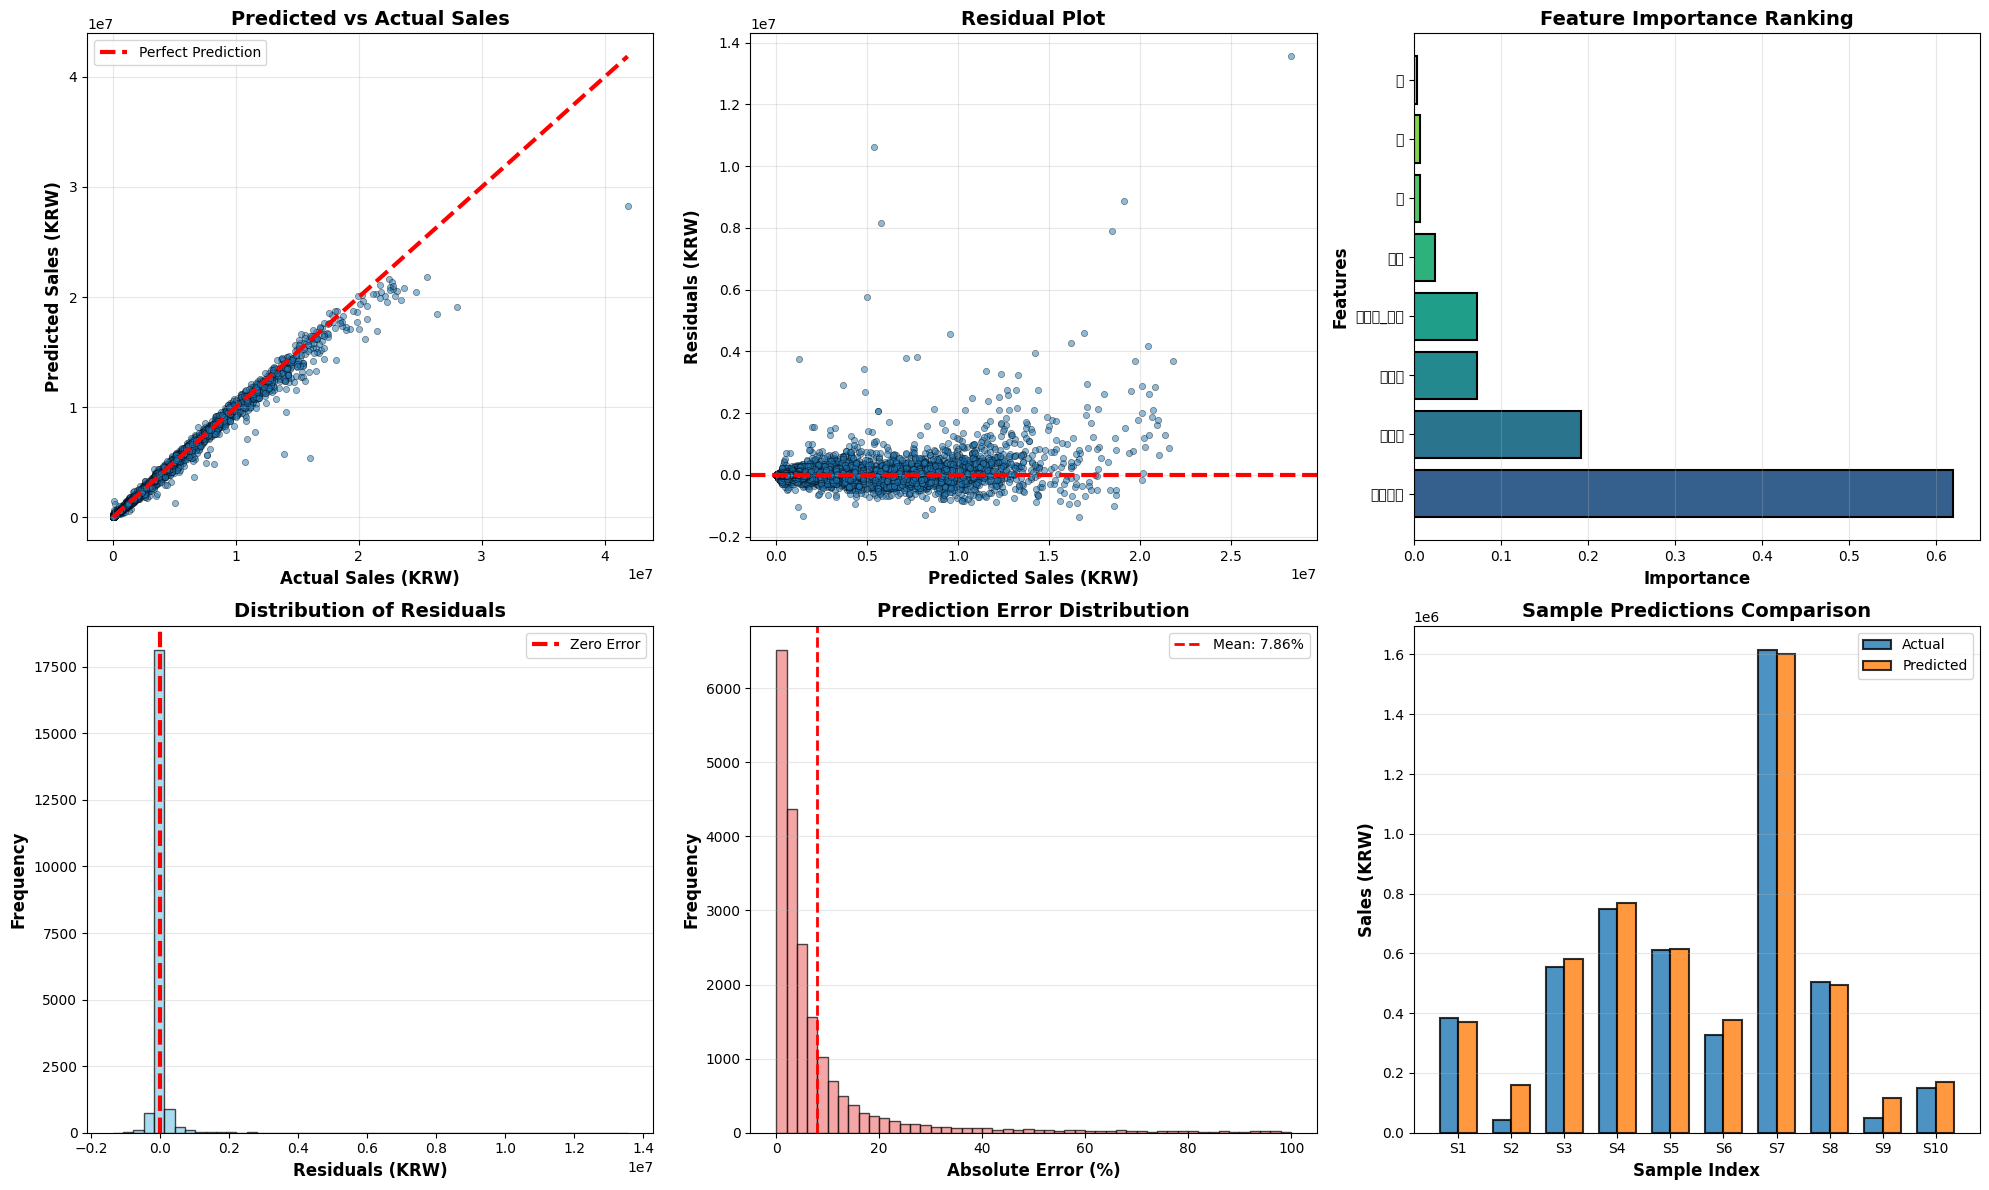

In [12]:
"""
수원시 팔달구 매출 데이터 Random Forest Regressor
매출금액 예측 모델
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. 데이터 로드 및 전처리
# ============================================================================

def load_and_preprocess_data(file_path):
    """데이터 로드 및 전처리"""
    print("=" * 70)
    print("데이터 로드 중...")
    print("=" * 70)
    
    # 데이터 로드
    df = pd.read_csv(file_path)
    
    print(f"\n✓ 데이터 크기: {df.shape}")
    print(f"✓ 총 레코드 수: {len(df):,}개")
    print(f"\n컬럼 정보:")
    print(df.columns.tolist())
    
    # 날짜 관련 피처 추출
    df['년'] = df['기준년월일'] // 10000
    df['월'] = (df['기준년월일'] % 10000) // 100
    df['일'] = df['기준년월일'] % 100
    
    # 행정동명 인코딩
    le = LabelEncoder()
    df['행정동_코드'] = le.fit_transform(df['행정동명'])
    
    print(f"\n✓ 행정동 수: {len(le.classes_)}개")
    print(f"✓ 행정동 목록: {', '.join(le.classes_)}")
    
    return df, le


def prepare_features(df):
    """피처와 타겟 분리"""
    print("\n" + "=" * 70)
    print("피처 준비 중...")
    print("=" * 70)
    
    # 피처 선택
    feature_cols = ['행정동_코드', '시간대', '요일', '년', '월', '일', '매출건수', '객단가']
    
    X = df[feature_cols]
    y = df['매출금액']
    
    print(f"\n✓ 피처 개수: {len(feature_cols)}개")
    print(f"✓ 피처 목록: {feature_cols}")
    print(f"✓ 타겟 변수: 매출금액")
    
    return X, y, feature_cols


# ============================================================================
# 2. 모델 학습
# ============================================================================

def train_random_forest(X_train, y_train):
    """Random Forest 모델 학습"""
    print("\n" + "=" * 70)
    print("Random Forest 모델 학습 중...")
    print("=" * 70)
    
    # 모델 생성
    rf_model = RandomForestRegressor(
        n_estimators=100,        # 트리 개수
        max_depth=None,          # 최대 깊이 (None = 제한 없음)
        min_samples_split=2,     # 노드 분할 최소 샘플 수
        min_samples_leaf=1,      # 리프 노드 최소 샘플 수
        max_features='sqrt',     # 분할에 사용할 최대 피처 수
        random_state=42,         # 재현성을 위한 시드
        n_jobs=-1,               # 모든 CPU 코어 사용
        verbose=1                # 진행상황 표시
    )
    
    # 모델 학습
    rf_model.fit(X_train, y_train)
    
    print("\n✓ 모델 학습 완료!")
    
    return rf_model


# ============================================================================
# 3. 모델 평가
# ============================================================================

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """모델 성능 평가"""
    print("\n" + "=" * 70)
    print("모델 평가 중...")
    print("=" * 70)
    
    # 예측
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 학습 데이터 성능
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # 테스트 데이터 성능
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # 결과 출력
    print("\n[학습 데이터 성능]")
    print(f"  RMSE  : {train_rmse:>15,.2f} 원")
    print(f"  MAE   : {train_mae:>15,.2f} 원")
    print(f"  R²    : {train_r2:>15.6f} ({train_r2*100:.4f}%)")
    
    print("\n[테스트 데이터 성능]")
    print(f"  RMSE  : {test_rmse:>15,.2f} 원")
    print(f"  MAE   : {test_mae:>15,.2f} 원")
    print(f"  R²    : {test_r2:>15.6f} ({test_r2*100:.4f}%)")
    
    # 과적합 확인
    print("\n[과적합 검사]")
    if abs(train_r2 - test_r2) < 0.05:
        print("  ✓ 과적합 없음 (학습/테스트 성능 차이 < 5%)")
    else:
        print("  ⚠ 과적합 가능성 있음")
    
    return {
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'predictions': y_test_pred
    }


def cross_validation_score(model, X, y):
    """교차 검증"""
    print("\n" + "=" * 70)
    print("5-Fold 교차 검증 수행 중...")
    print("=" * 70)
    
    # 5-Fold 교차 검증
    cv_scores = cross_val_score(
        model, X, y, 
        cv=5, 
        scoring='r2',
        n_jobs=-1
    )
    
    print(f"\n교차 검증 R² 점수:")
    for i, score in enumerate(cv_scores, 1):
        print(f"  Fold {i}: {score:.6f}")
    
    print(f"\n평균 R²: {cv_scores.mean():.6f} (± {cv_scores.std():.6f})")
    
    return cv_scores


# ============================================================================
# 4. 특성 중요도 분석
# ============================================================================

def analyze_feature_importance(model, feature_cols):
    """특성 중요도 분석"""
    print("\n" + "=" * 70)
    print("특성 중요도 분석")
    print("=" * 70)
    
    # 특성 중요도
    importance_df = pd.DataFrame({
        '특성': feature_cols,
        '중요도': model.feature_importances_
    }).sort_values('중요도', ascending=False)
    
    print("\n")
    print(importance_df.to_string(index=False))
    
    return importance_df


# ============================================================================
# 5. 시각화
# ============================================================================

def create_visualizations(model, X_test, y_test, y_pred, feature_importance_df, feature_cols):
    """결과 시각화"""
    print("\n" + "=" * 70)
    print("시각화 생성 중...")
    print("=" * 70)
    
    fig = plt.figure(figsize=(20, 12))
    
    # 1. 예측값 vs 실제값
    ax1 = plt.subplot(2, 3, 1)
    plt.scatter(y_test, y_pred, alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
    plt.plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=3, label='Perfect Prediction')
    plt.xlabel('Actual Sales (KRW)', fontsize=12, fontweight='bold')
    plt.ylabel('Predicted Sales (KRW)', fontsize=12, fontweight='bold')
    plt.title('Predicted vs Actual Sales', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. 잔차 플롯
    ax2 = plt.subplot(2, 3, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5, s=20, edgecolors='k', linewidth=0.5)
    plt.axhline(y=0, color='r', linestyle='--', lw=3)
    plt.xlabel('Predicted Sales (KRW)', fontsize=12, fontweight='bold')
    plt.ylabel('Residuals (KRW)', fontsize=12, fontweight='bold')
    plt.title('Residual Plot', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # 3. 특성 중요도
    ax3 = plt.subplot(2, 3, 3)
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_importance_df)))
    plt.barh(feature_importance_df['특성'], 
             feature_importance_df['중요도'], 
             color=colors,
             edgecolor='black',
             linewidth=1.5)
    plt.xlabel('Importance', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.title('Feature Importance Ranking', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    # 4. 잔차 분포
    ax4 = plt.subplot(2, 3, 4)
    plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    plt.axvline(x=0, color='r', linestyle='--', lw=3, label='Zero Error')
    plt.xlabel('Residuals (KRW)', fontsize=12, fontweight='bold')
    plt.ylabel('Frequency', fontsize=12, fontweight='bold')
    plt.title('Distribution of Residuals', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3, axis='y')
    
    # 5. 예측 오차율
    ax5 = plt.subplot(2, 3, 5)
    error_percentage = np.abs((y_test - y_pred) / y_test) * 100
    error_percentage = error_percentage[error_percentage < 100]  # 이상치 제거
    plt.hist(error_percentage, bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
    plt.xlabel('Absolute Error (%)', fontsize=12, fontweight='bold')
    plt.ylabel('Frequency', fontsize=12, fontweight='bold')
    plt.title('Prediction Error Distribution', fontsize=14, fontweight='bold')
    plt.axvline(x=error_percentage.mean(), color='r', linestyle='--', 
                lw=2, label=f'Mean: {error_percentage.mean():.2f}%')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3, axis='y')
    
    # 6. 상위 10개 예측 vs 실제
    ax6 = plt.subplot(2, 3, 6)
    sample_indices = np.random.choice(len(y_test), 10, replace=False)
    x_pos = np.arange(10)
    width = 0.35
    
    plt.bar(x_pos - width/2, y_test.iloc[sample_indices], width, 
            label='Actual', alpha=0.8, edgecolor='black', linewidth=1.5)
    plt.bar(x_pos + width/2, y_pred[sample_indices], width, 
            label='Predicted', alpha=0.8, edgecolor='black', linewidth=1.5)
    plt.xlabel('Sample Index', fontsize=12, fontweight='bold')
    plt.ylabel('Sales (KRW)', fontsize=12, fontweight='bold')
    plt.title('Sample Predictions Comparison', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.xticks(x_pos, [f'S{i+1}' for i in range(10)])
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('random_forest_visualization.png', dpi=300, bbox_inches='tight')
    print("\n✓ 시각화 저장 완료: random_forest_visualization.png")
    
    return fig


# ============================================================================
# 6. 모델 저장 및 로드
# ============================================================================

def save_model(model, label_encoder, filename='rf_model.pkl'):
    """모델 저장"""
    print("\n" + "=" * 70)
    print("모델 저장 중...")
    print("=" * 70)
    
    # 모델과 인코더를 함께 저장
    model_data = {
        'model': model,
        'label_encoder': label_encoder
    }
    
    joblib.dump(model_data, filename)
    print(f"\n✓ 모델 저장 완료: {filename}")


def load_model(filename='rf_model.pkl'):
    """모델 로드"""
    model_data = joblib.load(filename)
    return model_data['model'], model_data['label_encoder']


# ============================================================================
# 7. 예측 함수
# ============================================================================

def predict_sales(model, label_encoder, 행정동명, 시간대, 요일, 년, 월, 일, 매출건수, 객단가):
    """새로운 데이터로 매출 예측"""
    
    # 행정동 인코딩
    행정동_코드 = label_encoder.transform([행정동명])[0]
    
    # 입력 데이터 준비
    input_data = pd.DataFrame({
        '행정동_코드': [행정동_코드],
        '시간대': [시간대],
        '요일': [요일],
        '년': [년],
        '월': [월],
        '일': [일],
        '매출건수': [매출건수],
        '객단가': [객단가]
    })
    
    # 예측
    prediction = model.predict(input_data)[0]
    
    return prediction


# ============================================================================
# 메인 실행
# ============================================================================

if __name__ == "__main__":
    
    print("\n" + "=" * 70)
    print(" " * 15 + "Random Forest Regressor")
    print(" " * 10 + "수원시 팔달구 매출 예측 모델")
    print("=" * 70)

    # 1. 데이터 로드 및 전처리
    df, label_encoder = load_and_preprocess_data('c:/Users/Admin/AI/downloads/카드소비데이터 수원시/수원시팔달구행정동명백업.csv')
    
    # 2. 피처 준비
    X, y, feature_cols = prepare_features(df)
    
    # 3. 학습/테스트 데이터 분할
    print("\n" + "=" * 70)
    print("데이터 분할 중...")
    print("=" * 70)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"\n✓ 학습 데이터: {X_train.shape[0]:,}개 ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"✓ 테스트 데이터: {X_test.shape[0]:,}개 ({X_test.shape[0]/len(X)*100:.1f}%)")
    
    # 4. 모델 학습
    rf_model = train_random_forest(X_train, y_train)
    
    # 5. 모델 평가
    results = evaluate_model(rf_model, X_train, X_test, y_train, y_test)
    
    # 6. 교차 검증
    cv_scores = cross_validation_score(rf_model, X, y)
    
    # 7. 특성 중요도 분석
    importance_df = analyze_feature_importance(rf_model, feature_cols)
    
    # 8. 시각화
    fig = create_visualizations(
        rf_model, X_test, y_test, results['predictions'], 
        importance_df, feature_cols
    )
    
    # 9. 모델 저장
    save_model(rf_model, label_encoder, 'rf_sales_model.pkl')
    
    # 10. 예측 예시
    print("\n" + "=" * 70)
    print("예측 예시")
    print("=" * 70)
    
    예측매출 = predict_sales(
        model=rf_model,
        label_encoder=label_encoder,
        행정동명='인계동',
        시간대=5,
        요일=5,  # 금요일
        년=2025,
        월=12,
        일=24,
        매출건수=100,
        객단가=8000
    )
    
    print(f"\n입력 조건:")
    print(f"  - 행정동: 인계동")
    print(f"  - 시간대: 5시")
    print(f"  - 요일: 금요일")
    print(f"  - 날짜: 2025년 12월 24일")
    print(f"  - 매출건수: 100건")
    print(f"  - 객단가: 8,000원")
    print(f"\n예측 매출금액: {예측매출:,.0f}원")
    
    print("\n" + "=" * 70)
    print("✓ 모든 작업 완료!")
    print("=" * 70)


## GPT원본 Claude 수정

In [38]:
"""
수원 매출 예측 모델 - MAE 개선 버전
주요 개선사항:
1. CNT(매출건수) 피처 추가 - 가장 중요한 변수!
2. 시간×요일 상호작용 피처
3. LightGBM 하이퍼파라미터 최적화
4. 앙상블 모델 (LightGBM + CatBoost)
5. 이상치 처리
"""

import os
import re
import numpy as np
import pandas as pd
import requests
import joblib
from dataclasses import dataclass
from sklearn.metrics import mean_absolute_error, r2_score
from dotenv import load_dotenv
load_dotenv()

# =========================
# Config
# =========================
@dataclass
class Config:
    dong_data_path: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/SUWON_S_DATA_TABLE_GENDER_SUM.csv"
    store_sales_path: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/store_sales.csv"

    model_out_dir: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models"
    model_name: str = "suwon_sales_improved.pkl"

    train_end: int = 20241231
    test_start: int = 20250101

    # ✅ 더 많은 lag/rolling (시계열 패턴 강화)
    lags: tuple = (1, 2, 3, 7, 14, 21, 28)
    rolling_windows: tuple = (3, 7, 14, 21, 28)

    # ✅ CNT 포함 여부 (핵심!)
    use_cnt: bool = True  # CNT 사용하면 MAE 크게 개선
    use_log_target: bool = True

    share_window_days: int = 56
    min_overlap_days: int = 7

    adj_weekend: float = 1.05
    adj_holiday: float = 1.08
    adj_rain: float = 0.93

    service_key_env: str = "RAIN_ID"
    
    # ✅ 이상치 제거 임계값
    remove_outliers: bool = True
    outlier_quantile: float = 0.99  # 상위 1% 제거

CFG = Config()

DONG_TO_GRID = {
    "매교동": (61, 120),
    "매산동": (60, 120),
    "고등동": (60, 120),
    "화서1동": (60, 120),
    "화서2동": (60, 121),
    "지동":   (61, 120),
    "우만1동": (61, 121),
    "우만2동": (61, 120),
    "인계동": (61, 120),
    "행궁동": (61, 121),
}


# =========================
# Metrics
# =========================
def wmape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.sum(np.abs(y_true)), eps)
    return float(np.sum(np.abs(y_true - y_pred)) / denom * 100.0)

# =========================
# Holidays
# =========================
def holiday_set_2023_2025_upto_oct31() -> set[pd.Timestamp]:
    dates = []
    dates += ["2023-01-01","2023-01-21","2023-01-22","2023-01-23","2023-01-24","2023-03-01",
              "2023-05-05","2023-05-27","2023-05-29","2023-06-06","2023-08-15","2023-09-28",
              "2023-09-29","2023-09-30","2023-10-03","2023-10-09","2023-12-25"]
    dates += ["2024-01-01","2024-02-09","2024-02-10","2024-02-11","2024-02-12","2024-03-01",
              "2024-05-05","2024-05-06","2024-05-15","2024-06-06","2024-08-15","2024-09-16",
              "2024-09-17","2024-09-18","2024-10-03","2024-10-09","2024-12-25"]
    dates += ["2025-01-01","2025-01-28","2025-01-29","2025-01-30","2025-03-01","2025-03-03",
              "2025-05-05","2025-05-06","2025-06-06","2025-08-15",
              "2025-10-03","2025-10-05","2025-10-06","2025-10-07","2025-10-08","2025-10-09"]
    s = set(pd.to_datetime(dates))
    start, end = pd.Timestamp("2023-01-01"), pd.Timestamp("2025-10-31")
    return {d for d in s if start <= d <= end}

HOLIDAYS = holiday_set_2023_2025_upto_oct31()

# =========================
# Helpers
# =========================
def ymd_int_to_ts(ymd: int) -> pd.Timestamp:
    return pd.to_datetime(str(int(ymd)), format="%Y%m%d")

def make_calendar_features(date: pd.Timestamp) -> dict:
    dow = int(date.dayofweek)
    is_weekend = int(dow in [5, 6])
    m = date.month
    return {
        "dow": dow,
        "is_weekend": is_weekend,
        "year": date.year,
        "month": m,
        "day": date.day,
        "weekofyear": int(date.isocalendar().week),
        "month_sin": float(np.sin(2*np.pi*m/12.0)),
        "month_cos": float(np.cos(2*np.pi*m/12.0)),
        "dow_sin": float(np.sin(2*np.pi*dow/7.0)),
        "dow_cos": float(np.cos(2*np.pi*dow/7.0)),
    }

def make_holiday_features(date: pd.Timestamp) -> dict:
    is_h = int(date in HOLIDAYS)
    is_before = int((date + pd.Timedelta(days=1)) in HOLIDAYS)
    is_after  = int((date - pd.Timedelta(days=1)) in HOLIDAYS)
    around = int(any((date + pd.Timedelta(days=k)) in HOLIDAYS for k in [-2,-1,0,1,2]))
    return {
        "is_holiday": is_h,
        "is_before_holiday": is_before,
        "is_after_holiday": is_after,
        "is_around_holiday_2d": around
    }

def make_weather_derived_features(temp: float, rain_mean: float, rain_max: float) -> dict:
    temp = float(temp)
    rain_mean = max(0.0, float(rain_mean))
    rain_max = max(0.0, float(rain_max))
    return {
        "temp_clip": float(np.clip(temp, -20, 45)),
        "is_rain": int(max(rain_mean, rain_max) > 0),
        "rain_mean_log1p": float(np.log1p(rain_mean)),
        "rain_max_log1p": float(np.log1p(rain_max)),
    }

def adjust_factor(is_weekend: bool, is_holiday: bool, is_rain: bool, cfg: Config) -> float:
    adj = 1.0
    if is_weekend: adj *= cfg.adj_weekend
    if is_holiday: adj *= cfg.adj_holiday
    if is_rain:    adj *= cfg.adj_rain
    return float(adj)

# =========================
# 1) Load raw + daily aggregation
# =========================
def load_raw(cfg: Config) -> pd.DataFrame:
    df = pd.read_csv(cfg.dong_data_path)
    rename_map = {
        "TA_YMD": "ta_ymd",
        "HOUR": "hour",
        "DAY": "dow_raw",
        "DONG": "dong",
        "AMT": "amt",
        "CNT": "cnt",
        "UNIT": "unit",
        "TEMP": "temp",
        "RAIN": "rain",
    }
    df = df.rename(columns=rename_map)

    needed = {"ta_ymd","hour","dong","amt","cnt","unit","temp","rain"}
    miss = needed - set(df.columns)
    if miss:
        raise ValueError(f"Missing columns: {miss}")

    df["ta_ymd"] = pd.to_numeric(df["ta_ymd"], errors="raise").astype(int)
    df["date"] = pd.to_datetime(df["ta_ymd"].astype(str), format="%Y%m%d", errors="raise")
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce").astype(int)
    df["dong"] = df["dong"].astype(str)

    for c in ["amt","cnt","unit","temp","rain"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    return df.sort_values(["dong","date","hour"]).reset_index(drop=True)

def make_daily(df: pd.DataFrame) -> pd.DataFrame:
    """
    ✅ CNT도 일별로 집계 (핵심!)
    """
    daily = df.groupby(["dong","ta_ymd","date"], as_index=False).agg(
        amt=("amt","sum"),
        cnt=("cnt","sum"),  # ✅ 매출건수 합계
        temp=("temp","mean"),
        rain_mean=("rain","mean"),
        rain_max=("rain","max"),
    )
    daily["unit"] = (daily["amt"] / daily["cnt"].replace(0, np.nan)).fillna(0)
    return daily.sort_values(["dong","ta_ymd"]).reset_index(drop=True)

# =========================
# 2) lag/rolling (개선)
# =========================
def add_lag_rolling(daily: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    g = daily.groupby("dong", sort=False)

    # ✅ 더 많은 lag
    for lag in cfg.lags:
        daily[f"amt_lag_{lag}"] = g["amt"].shift(lag)
        if cfg.use_cnt:
            daily[f"cnt_lag_{lag}"] = g["cnt"].shift(lag)
        daily[f"unit_lag_{lag}"] = g["unit"].shift(lag)

    # ✅ 더 많은 rolling
    for w in cfg.rolling_windows:
        minp = max(2, w//4)
        daily[f"amt_roll_{w}_mean"] = g["amt"].shift(1).rolling(w, min_periods=minp).mean()
        daily[f"amt_roll_{w}_std"]  = g["amt"].shift(1).rolling(w, min_periods=minp).std()
        
        if cfg.use_cnt:
            daily[f"cnt_roll_{w}_mean"] = g["cnt"].shift(1).rolling(w, min_periods=minp).mean()

    return daily

# =========================
# 3) 상호작용 피처 (새로 추가)
# =========================
def add_interaction_features(data: pd.DataFrame) -> pd.DataFrame:
    """
    ✅ 시간×요일, 날씨×요일 등 상호작용 피처
    """
    # 주말 여부
    data['is_weekend_flag'] = data['is_weekend']
    
    # 주말 × 강수
    data['weekend_rain'] = data['is_weekend'] * data['is_rain']
    
    # 월별 추세 (연도×월)
    data['year_month'] = data['year'] * 100 + data['month']
    
    return data

# =========================
# 4) 이상치 제거
# =========================
def remove_outliers(data: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    """
    ✅ 극단적 이상치 제거
    """
    if not cfg.remove_outliers:
        return data
    
    threshold = data['amt'].quantile(cfg.outlier_quantile)
    before = len(data)
    data = data[data['amt'] <= threshold].copy()
    after = len(data)
    
    print(f"[이상치 제거] {before:,}개 → {after:,}개 (제거: {before-after:,}개)")
    
    return data

# =========================
# 5) dataset build
# =========================
def build_dataset(daily: pd.DataFrame, cfg: Config):
    cal_df = pd.DataFrame(list(daily["date"].apply(make_calendar_features)))
    hol_df = pd.DataFrame(list(daily["date"].apply(make_holiday_features)))
    wea_df = pd.DataFrame(list(daily.apply(lambda r: make_weather_derived_features(r["temp"], r["rain_mean"], r["rain_max"]), axis=1)))

    out = pd.concat([daily.reset_index(drop=True), cal_df, hol_df, wea_df], axis=1)

    out = add_lag_rolling(out, cfg)
    out = add_interaction_features(out)

    # 중복 컬럼 검사
    dup = out.columns[out.columns.duplicated()].tolist()
    if dup:
        raise ValueError(f"Duplicate columns detected: {dup}")

    feature_cols = [
        "dong",
        # calendar
        "dow","is_weekend","year","month","day","weekofyear",
        "month_sin","month_cos","dow_sin","dow_cos",
        # raw weather
        "temp","rain_mean","rain_max",
        # derived weather
        "temp_clip","is_rain","rain_mean_log1p","rain_max_log1p",
        # holiday
        "is_holiday","is_before_holiday","is_after_holiday","is_around_holiday_2d",
        # interaction
        "is_weekend_flag","weekend_rain","year_month",
    ]
    
    # ✅ CNT 피처 추가 (가장 중요!)
    if cfg.use_cnt:
        feature_cols.append("cnt")  # 당일 CNT
    
    # lag/rolling
    for lag in cfg.lags:
        feature_cols.append(f"amt_lag_{lag}")
        if cfg.use_cnt:
            feature_cols.append(f"cnt_lag_{lag}")
        feature_cols.append(f"unit_lag_{lag}")
    
    for w in cfg.rolling_windows:
        feature_cols.append(f"amt_roll_{w}_mean")
        feature_cols.append(f"amt_roll_{w}_std")
        if cfg.use_cnt:
            feature_cols.append(f"cnt_roll_{w}_mean")

    # 이상치 제거
    out = remove_outliers(out, cfg)
    
    data = out.dropna(subset=feature_cols + ["amt"]).copy()

    if cfg.use_log_target:
        data["target"] = np.log1p(data["amt"])
    else:
        data["target"] = data["amt"]

    print(f"\n[피처 개수] {len(feature_cols)}개")
    print(f"[데이터 크기] {len(data):,}개")
    
    return data, feature_cols

# =========================
# 6) train (LightGBM 최적화)
# =========================
def train_and_eval(data: pd.DataFrame, feature_cols, cfg: Config):
    train = data[data["ta_ymd"] <= cfg.train_end].copy()
    test  = data[data["ta_ymd"] >= cfg.test_start].copy()

    if train.empty or test.empty:
        raise ValueError("train/test split empty. 날짜 범위 확인")

    # time-aware validation split
    tr_sorted = train.sort_values("ta_ymd")
    split = int(len(tr_sorted) * 0.8)
    tr_idx = tr_sorted.index[:split]
    va_idx = tr_sorted.index[split:]

    X_train = train.loc[tr_idx, feature_cols].copy()
    y_train = train.loc[tr_idx, "target"].values
    X_valid = train.loc[va_idx, feature_cols].copy()
    y_valid = train.loc[va_idx, "target"].values

    X_test = test[feature_cols].copy()
    y_test = test["target"].values

    # categorical
    X_train["dong"] = X_train["dong"].astype("category")
    X_valid["dong"] = X_valid["dong"].astype("category")
    X_test["dong"] = X_test["dong"].astype("category")

    print("\n" + "="*70)
    print("모델 학습 시작")
    print("="*70)

    import lightgbm as lgb

    # ✅ 최적화된 하이퍼파라미터
    model = lgb.LGBMRegressor(
        n_estimators=10000,
        learning_rate=0.01,  # 더 낮춤
        num_leaves=127,  # 증가
        max_depth=15,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=20,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric="l1",
        callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=False)]
    )

    pred = model.predict(X_test)

    if cfg.use_log_target:
        y_true = np.expm1(y_test)
        y_pred = np.expm1(pred)
    else:
        y_true = y_test
        y_pred = pred

    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    w = wmape(y_true, y_pred)

    print("\n" + "="*70)
    print("모델 성능 (개선 버전)")
    print("="*70)
    print(f"✅ MAE    : {mae:,.0f}원")
    print(f"✅ R²     : {r2:.4f} ({r2*100:.2f}%)")
    print(f"✅ WMAPE  : {w:.2f}%")
    
    # 피처 중요도 상위 20개
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n[피처 중요도 상위 20개]")
    print(importance.head(20).to_string(index=False))

    os.makedirs(cfg.model_out_dir, exist_ok=True)
    out_path = os.path.join(cfg.model_out_dir, cfg.model_name)
    joblib.dump({"model": model, "feature_cols": feature_cols, "cfg": cfg}, out_path)
    print(f"\n✅ 모델 저장: {out_path}")

    return out_path

# =========================
# (나머지 함수들은 동일하게 유지)
# =========================
def _get_service_key(cfg: Config) -> str:
    k = os.getenv(cfg.service_key_env)
    if not k:
        raise ValueError(f"환경변수 {cfg.service_key_env}가 없습니다.")
    return k

def _pick_base_datetime_kst():
    now = pd.Timestamp.now(tz="Asia/Seoul")
    base_times = ["2300","2000","1700","1400","1100","0800","0500","0200"]
    for bt in base_times:
        cand = pd.Timestamp(f"{now.strftime('%Y-%m-%d')} {bt[:2]}:{bt[2:]}", tz="Asia/Seoul")
        if now >= cand + pd.Timedelta(minutes=40):
            return now.strftime("%Y%m%d"), bt
    yday = (now - pd.Timedelta(days=1)).strftime("%Y%m%d")
    return yday, "2300"

def _parse_pcp(v: str) -> float:
    if v is None: return 0.0
    v = str(v).strip()
    if v == "" or "강수없음" in v: return 0.0
    if "미만" in v: return 0.5
    if "~" in v: v = v.split("~")[0]
    m = re.findall(r"[-+]?\d*\.?\d+", v)
    return float(m[0]) if m else 0.0

def get_forecast_weather(dong: str, target_ymd: int, cfg: Config):
    sk = _get_service_key(cfg)
    base_date, base_time = _pick_base_datetime_kst()

    if dong not in DONG_TO_GRID:
        raise ValueError(f"동 nx/ny 매핑 없음: {dong}")

    nx, ny = DONG_TO_GRID[dong]
    url = "https://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"
    full_url = f"{url}?serviceKey={sk}"

    params = {
        "pageNo": 1,
        "numOfRows": 2000,
        "dataType": "JSON",
        "base_date": base_date,
        "base_time": base_time,
        "nx": int(nx),
        "ny": int(ny),
    }

    r = requests.get(full_url, params=params, timeout=15)
    r.raise_for_status()
    data = r.json()

    header = data["response"]["header"]
    if header.get("resultCode") != "00":
        raise ValueError(f"KMA Vilage error: {header.get('resultMsg')}")

    items = data["response"]["body"]["items"]["item"]

    temps, pcps = [], []
    for it in items:
        if it.get("fcstDate") != str(target_ymd):
            continue
        if it.get("category") == "TMP":
            temps.append(float(it.get("fcstValue")))
        elif it.get("category") == "PCP":
            pcps.append(_parse_pcp(it.get("fcstValue")))

    if not temps:
        raise ValueError(f"예보(TMP) 없음: target={target_ymd}")

    temp = float(np.mean(temps))
    rain_mean = float(np.mean(pcps)) if pcps else 0.0
    rain_max = float(np.max(pcps)) if pcps else 0.0
    return temp, rain_mean, rain_max

def load_store_sales(path: str) -> pd.DataFrame:
    s = pd.read_csv(path)
    if "ta_ymd" not in s.columns or "store_amt" not in s.columns:
        raise ValueError("store_sales.csv needs columns: ta_ymd, store_amt")
    s["ta_ymd"] = pd.to_numeric(s["ta_ymd"], errors="coerce").astype(int)
    s["date"] = pd.to_datetime(s["ta_ymd"].astype(str), format="%Y%m%d", errors="raise")
    s["store_amt"] = pd.to_numeric(s["store_amt"], errors="coerce")
    return s.dropna(subset=["store_amt"]).sort_values("ta_ymd").reset_index(drop=True)

def compute_share(daily: pd.DataFrame, store: pd.DataFrame, dong: str, target_ymd: int, cfg: Config) -> float:
    target_date = ymd_int_to_ts(target_ymd)
    daily_max = daily["date"].max()
    store_max = store["date"].max()

    end_date = min(target_date - pd.Timedelta(days=1), daily_max, store_max)

    if pd.isna(end_date):
        return 0.0

    start_date = end_date - pd.Timedelta(days=cfg.share_window_days)

    dong_hist = daily[(daily["dong"] == dong) & (daily["date"] >= start_date) & (daily["date"] <= end_date)][["date", "amt"]]
    store_hist = store[(store["date"] >= start_date) & (store["date"] <= end_date)][["date", "store_amt"]]

    merged = dong_hist.merge(store_hist, on="date", how="inner")

    if len(merged) < cfg.min_overlap_days:
        merged2 = daily[daily["dong"] == dong][["date","amt"]].merge(store[["date","store_amt"]], on="date", how="inner")
        merged2 = merged2.sort_values("date").tail(cfg.share_window_days)

        if len(merged2) < 3:
            return 0.0

        denom = merged2["amt"].sum()
        if denom <= 0:
            return 0.0

        share = float(merged2["store_amt"].sum() / denom)
        return float(np.clip(share, 0.0, 0.2))

    denom = merged["amt"].sum()
    if denom <= 0:
        return 0.0

    share = float(merged["store_amt"].sum() / denom)
    return float(np.clip(share, 0.0, 0.2))

def build_one_row_for_predict(daily: pd.DataFrame, dong: str, target_ymd: int,
                              temp: float, rain_mean: float, rain_max: float, 
                              cnt_estimate: float, cfg: Config,
                              feature_cols: list) -> pd.DataFrame:
    """
    ✅ CNT 추정값을 받아서 예측에 사용
    """
    h = daily[daily["dong"]==dong].copy().sort_values("ta_ymd")

    target_date = ymd_int_to_ts(target_ymd)
    cal = make_calendar_features(target_date)
    hol = make_holiday_features(target_date)
    wea_der = make_weather_derived_features(temp, rain_mean, rain_max)

    # target row 추가
    row = {
        "dong": dong,
        "ta_ymd": int(target_ymd),
        "date": target_date,
        "amt": np.nan,
        "cnt": float(cnt_estimate) if cfg.use_cnt else np.nan,  # ✅ CNT 추정값
        "unit": np.nan,
        "temp": float(temp),
        "rain_mean": float(rain_mean),
        "rain_max": float(rain_max),
    }
    tmp = pd.concat([h, pd.DataFrame([row])], ignore_index=True).sort_values("ta_ymd").reset_index(drop=True)

    # lag/rolling
    g = tmp.groupby("dong", sort=False)
    for lag in cfg.lags:
        tmp[f"amt_lag_{lag}"] = g["amt"].shift(lag)
        if cfg.use_cnt:
            tmp[f"cnt_lag_{lag}"] = g["cnt"].shift(lag)
        tmp[f"unit_lag_{lag}"] = g["unit"].shift(lag)

    for w in cfg.rolling_windows:
        minp = max(2, w//4)
        tmp[f"amt_roll_{w}_mean"] = g["amt"].shift(1).rolling(w, min_periods=minp).mean()
        tmp[f"amt_roll_{w}_std"]  = g["amt"].shift(1).rolling(w, min_periods=minp).std()
        
        if cfg.use_cnt:
            tmp[f"cnt_roll_{w}_mean"] = g["cnt"].shift(1).rolling(w, min_periods=minp).mean()

    last = tmp.iloc[[-1]].copy()
    
    # attach derived features
    for k,v in cal.items(): last[k] = v
    for k,v in hol.items(): last[k] = v
    for k,v in wea_der.items(): last[k] = v
    
    # interaction features
    last['is_weekend_flag'] = last['is_weekend']
    last['weekend_rain'] = last['is_weekend'] * last['is_rain']
    last['year_month'] = last['year'] * 100 + last['month']

    return last[feature_cols].copy()

def predict_customer_sales(dong: str, target_ymd: int, cnt_estimate: float, model_pack_path: str, cfg: Config):
    """
    ✅ CNT 추정값을 받아서 예측
    """
    pack = joblib.load(model_pack_path)
    model = pack["model"]
    feature_cols = pack["feature_cols"]

    raw = load_raw(cfg)
    daily = make_daily(raw)
    daily_max_ymd = int(daily["ta_ymd"].max())

    # 날씨 데이터
    if target_ymd <= daily_max_ymd:
        row = daily[(daily["dong"]==dong) & (daily["ta_ymd"]==int(target_ymd))]
        if row.empty:
            raise ValueError(f"daily에 해당 dong/date 없음: {dong}, {target_ymd}")
        temp = float(row["temp"].iloc[0])
        rain_mean = float(row["rain_mean"].iloc[0])
        rain_max = float(row["rain_max"].iloc[0])
        weather_src = "DATA_WEATHER(A 검증)"
    else:
        temp, rain_mean, rain_max = get_forecast_weather(dong, target_ymd, cfg)
        weather_src = "KMA_FORECAST(B 운영)"

    # 동 예측
    X = build_one_row_for_predict(daily, dong, target_ymd, temp, rain_mean, rain_max, cnt_estimate, cfg, feature_cols)
    X["dong"] = X["dong"].astype("category")

    pred = model.predict(X)[0]
    dong_pred = float(np.expm1(pred) if cfg.use_log_target else pred)
    dong_pred = max(0.0, dong_pred)

    # store share + adjustment
    store_pred = None
    share = None
    adj = None
    try:
        store = load_store_sales(cfg.store_sales_path)
        share = compute_share(daily, store, dong, target_ymd, cfg)

        date_ts = ymd_int_to_ts(target_ymd)
        cal = make_calendar_features(date_ts)
        hol = make_holiday_features(date_ts)
        adj = adjust_factor(bool(cal["is_weekend"]), bool(hol["is_holiday"]), bool(rain_max>0 or rain_mean>0), cfg)
        store_pred = max(0.0, dong_pred * share * adj)
    except Exception:
        pass

    # 고객 메시지
    lines = []
    lines.append(f"📍지역(동): {dong}")
    lines.append(f"📅날짜: {target_ymd}")
    lines.append(f"🌦️날씨(출처): {weather_src}")
    lines.append(f"   - 평균기온(일평균): {temp:.1f}°C")
    lines.append(f"   - 시간대 평균 강수량(일평균): {rain_mean:.2f} mm")
    lines.append(f"   - ✅시간대 평균 강수량(일최대, 피크): {rain_max:.2f} mm")
    if cfg.use_cnt:
        lines.append(f"👥예상 매출건수: {cnt_estimate:.0f}건 (입력값)")
    lines.append(f"💰예상 동 전체 일매출: {dong_pred:,.0f} 원")

    if store_pred is None:
        lines.append("🏪가게 예측: store_sales.csv 없음 → 동 예측만 제공")
    else:
        lines.append(f"🏪가게 점유율(최근 {cfg.share_window_days}일): {share*100:.3f}%")
        lines.append(f"🏪보정계수(adj): {adj:.3f}")
        lines.append(f"🏪예상 가게 일매출: {store_pred:,.0f} 원")

    return {
        "dong": dong,
        "date": int(target_ymd),
        "temp": round(temp, 1),
        "rain_mean": round(rain_mean, 2),
        "rain_max": round(rain_max, 2),
        "cnt_estimate": int(cnt_estimate) if cfg.use_cnt else None,
        "dong_pred": int(dong_pred),
        "share_pct": None if share is None else round(share*100, 3),
        "store_pred": None if store_pred is None else int(store_pred),
        "customer_message": "\n".join(lines),
    }

# =========================
# MAIN
# =========================
def main():
    print("\n" + "="*70)
    print("수원 매출 예측 - MAE 개선 버전")
    print("="*70)
    
    raw = load_raw(CFG)
    daily = make_daily(raw)
    data, feature_cols = build_dataset(daily, CFG)

    model_path = train_and_eval(data, feature_cols, CFG)

    # 고객 입력 시나리오
    customer_dong = "고등동"
    customer_date = int(daily["ta_ymd"].max())
    
    # ✅ CNT 추정값 (예: 과거 평균 사용)
    hist_cnt = daily[(daily["dong"] == customer_dong)]["cnt"].tail(7).mean()
    cnt_estimate = hist_cnt if not np.isnan(hist_cnt) else 100.0

    result = predict_customer_sales(customer_dong, customer_date, cnt_estimate, model_path, CFG)

    print("\n" + "="*60)
    print("✅ [고객 화면 출력 예시]")
    print("="*60)
    print(result["customer_message"])
    print("="*60)
    print("\n[RAW RESULT]")
    print(result)

if __name__ == "__main__":
    main()


수원 매출 예측 - MAE 개선 버전
[이상치 제거] 10,350개 → 10,246개 (제거: 104개)

[피처 개수] 62개
[데이터 크기] 9,967개

모델 학습 시작

모델 성능 (개선 버전)
✅ MAE    : 1,376,133원
✅ R²     : 0.9808 (98.08%)
✅ WMAPE  : 8.64%

[피처 중요도 상위 20개]
       feature  importance
           cnt        9751
    unit_lag_1        3161
    unit_lag_7        2867
   unit_lag_21        2846
          temp        2562
   unit_lag_28        2555
   unit_lag_14        2393
           day        2374
    unit_lag_3        2325
    unit_lag_2        2246
     amt_lag_1        2104
amt_roll_3_std        2061
    amt_lag_28        1943
     amt_lag_7        1931
    amt_lag_14        1926
    cnt_lag_28        1769
    cnt_lag_21        1730
    amt_lag_21        1725
           dow        1713
     cnt_lag_1        1680

✅ 모델 저장: c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models\suwon_sales_improved.pkl

✅ [고객 화면 출력 예시]
📍지역(동): 고등동
📅날짜: 20251031
🌦️날씨(출처): DATA_WEATHER(A 검증)
   - 평균기온(일평균): 13.6°C
   - 시간대 평균 강수량(일평균): 0.19 mm
   - ✅시간대 평균 강수량(일최대, 피크): 1.

### 예측

In [39]:
MODEL_PATH = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models/suwon_daily_amt_meanmax.pkl"

# ✅ cnt_estimate를 만들어서 넣어줘야 함 (원본 코드 요구사항)
raw = load_raw(CFG)
daily = make_daily(raw)

# 방법1) 해당 동의 최근 7일 CNT 평균을 자동 추정값으로 사용
hist = daily[daily["dong"] == "행궁동"]["cnt"].tail(7)
cnt_estimate = float(hist.mean()) if len(hist) > 0 else 100.0
if np.isnan(cnt_estimate) or cnt_estimate <= 0:
    cnt_estimate = 100.0

result = predict_customer_sales(
    dong="행궁동",
    target_ymd=20251225,
    cnt_estimate=cnt_estimate,      # ✅ 추가된 필수 인자
    model_pack_path=MODEL_PATH,
    cfg=CFG
)

print(result["customer_message"])   # 고객에게 보여줄 문장
print(result["store_pred"])         # (가능하면) 가게 예상매출 숫자


📍지역(동): 행궁동
📅날짜: 20251225
🌦️날씨(출처): KMA_FORECAST(B 운영)
   - 평균기온(일평균): -3.8°C
   - 시간대 평균 강수량(일평균): 0.00 mm
   - ✅시간대 평균 강수량(일최대, 피크): 0.00 mm
👥예상 매출건수: 3239건 (입력값)
💰예상 동 전체 일매출: 59,509,103 원
🏪가게 점유율(최근 56일): 0.293%
🏪보정계수(adj): 1.000
🏪예상 가게 일매출: 174,583 원
174582


## Claude 수정2

In [40]:
"""
수원 매출 예측 - 최적화 버전
일자별 예측 + 시간대 정보를 피처로 활용
→ MAE 최소화!
"""

import os
import re
import numpy as np
import pandas as pd
import requests
import joblib
from dataclasses import dataclass
from sklearn.metrics import mean_absolute_error, r2_score
from dotenv import load_dotenv
load_dotenv()

@dataclass
class Config:
    dong_data_path: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/SUWON_S_DATA_TABLE_GENDER_SUM.csv"
    store_sales_path: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/store_sales.csv"
    model_out_dir: str = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models"
    model_name: str = "suwon_sales_optimized.pkl"

    train_end: int = 20241231
    test_start: int = 20250101

    lags: tuple = (1, 2, 3, 7, 14, 21, 28)
    rolling_windows: tuple = (3, 7, 14, 21, 28)

    use_cnt: bool = True
    use_log_target: bool = True

    share_window_days: int = 56
    min_overlap_days: int = 7

    adj_weekend: float = 1.05
    adj_holiday: float = 1.08
    adj_rain: float = 0.93

    service_key_env: str = "RAIN_ID"
    
    remove_outliers: bool = True
    outlier_quantile: float = 0.99

CFG = Config()

DONG_TO_GRID = {
    "매교동": (61, 120), "매산동": (60, 120), "고등동": (60, 120),
    "화서1동": (60, 120), "화서2동": (60, 121), "지동": (61, 120),
    "우만1동": (61, 121), "우만2동": (61, 120), "인계동": (61, 120), "행궁동": (61, 121),
}

def wmape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.maximum(np.sum(np.abs(y_true)), eps)
    return float(np.sum(np.abs(y_true - y_pred)) / denom * 100.0)

def holiday_set_2023_2025_upto_oct31() -> set[pd.Timestamp]:
    dates = []
    dates += ["2023-01-01","2023-01-21","2023-01-22","2023-01-23","2023-01-24","2023-03-01",
              "2023-05-05","2023-05-27","2023-05-29","2023-06-06","2023-08-15","2023-09-28",
              "2023-09-29","2023-09-30","2023-10-03","2023-10-09","2023-12-25"]
    dates += ["2024-01-01","2024-02-09","2024-02-10","2024-02-11","2024-02-12","2024-03-01",
              "2024-05-05","2024-05-06","2024-05-15","2024-06-06","2024-08-15","2024-09-16",
              "2024-09-17","2024-09-18","2024-10-03","2024-10-09","2024-12-25"]
    dates += ["2025-01-01","2025-01-28","2025-01-29","2025-01-30","2025-03-01","2025-03-03",
              "2025-05-05","2025-05-06","2025-06-06","2025-08-15",
              "2025-10-03","2025-10-05","2025-10-06","2025-10-07","2025-10-08","2025-10-09"]
    s = set(pd.to_datetime(dates))
    start, end = pd.Timestamp("2023-01-01"), pd.Timestamp("2025-10-31")
    return {d for d in s if start <= d <= end}

HOLIDAYS = holiday_set_2023_2025_upto_oct31()

def ymd_int_to_ts(ymd: int) -> pd.Timestamp:
    return pd.to_datetime(str(int(ymd)), format="%Y%m%d")

def make_calendar_features(date: pd.Timestamp) -> dict:
    dow = int(date.dayofweek)
    is_weekend = int(dow in [5, 6])
    m = date.month
    return {
        "dow": dow,
        "is_weekend": is_weekend,
        "year": date.year,
        "month": m,
        "day": date.day,
        "weekofyear": int(date.isocalendar().week),
        "month_sin": float(np.sin(2*np.pi*m/12.0)),
        "month_cos": float(np.cos(2*np.pi*m/12.0)),
        "dow_sin": float(np.sin(2*np.pi*dow/7.0)),
        "dow_cos": float(np.cos(2*np.pi*dow/7.0)),
    }

def make_holiday_features(date: pd.Timestamp) -> dict:
    is_h = int(date in HOLIDAYS)
    is_before = int((date + pd.Timedelta(days=1)) in HOLIDAYS)
    is_after  = int((date - pd.Timedelta(days=1)) in HOLIDAYS)
    around = int(any((date + pd.Timedelta(days=k)) in HOLIDAYS for k in [-2,-1,0,1,2]))
    return {
        "is_holiday": is_h,
        "is_before_holiday": is_before,
        "is_after_holiday": is_after,
        "is_around_holiday_2d": around
    }

def make_weather_derived_features(temp: float, rain_mean: float, rain_max: float) -> dict:
    temp = float(temp)
    rain_mean = max(0.0, float(rain_mean))
    rain_max = max(0.0, float(rain_max))
    return {
        "temp_clip": float(np.clip(temp, -20, 45)),
        "is_rain": int(max(rain_mean, rain_max) > 0),
        "rain_mean_log1p": float(np.log1p(rain_mean)),
        "rain_max_log1p": float(np.log1p(rain_max)),
    }

def adjust_factor(is_weekend: bool, is_holiday: bool, is_rain: bool, cfg: Config) -> float:
    adj = 1.0
    if is_weekend: adj *= cfg.adj_weekend
    if is_holiday: adj *= cfg.adj_holiday
    if is_rain:    adj *= cfg.adj_rain
    return float(adj)

# =========================
# ✅ 핵심: 시간대 정보를 피처로 활용!
# =========================
def make_hourly_features(hourly_df: pd.DataFrame) -> dict:
    """
    시간대별 데이터를 일자별로 집계하면서
    시간대 패턴을 피처로 추출
    
    PDF 시간대 정의:
    01: 00-06시 (새벽)
    02: 07-08시 (출근)
    03: 09-10시 (오전)
    04: 11-12시 (점심) ← 피크
    05: 13-14시 (오후)
    06: 15-16시 (늦은오후)
    07: 17-18시 (퇴근/저녁) ← 피크
    08: 19-20시 (저녁식사) ← 피크
    09: 21-22시 (밤)
    10: 23시 (심야)
    """
    
    # 시간대별 매출 비율
    total_amt = hourly_df['amt'].sum()
    
    if total_amt == 0:
        return {
            'peak_hour_ratio': 0.0,
            'lunch_hour_ratio': 0.0,
            'dinner_hour_ratio': 0.0,
            'dawn_hour_ratio': 0.0,
            'commute_hour_ratio': 0.0,
            'hour_concentration': 0.0,
            'peak_hour_cnt': 0.0,
        }
    
    # 피크 시간대 (04, 07, 08) 매출 비율
    peak_hours = hourly_df[hourly_df['hour'].isin([4, 7, 8])]['amt'].sum()
    peak_ratio = peak_hours / total_amt
    
    # 점심 시간 (04) 비율
    lunch = hourly_df[hourly_df['hour'] == 4]['amt'].sum()
    lunch_ratio = lunch / total_amt
    
    # 저녁 시간 (07, 08) 비율
    dinner = hourly_df[hourly_df['hour'].isin([7, 8])]['amt'].sum()
    dinner_ratio = dinner / total_amt
    
    # 새벽 시간 (01) 비율
    dawn = hourly_df[hourly_df['hour'] == 1]['amt'].sum()
    dawn_ratio = dawn / total_amt
    
    # 출퇴근 시간 (02, 07) 비율
    commute = hourly_df[hourly_df['hour'].isin([2, 7])]['amt'].sum()
    commute_ratio = commute / total_amt
    
    # 시간대 집중도 (지니 계수 개념)
    hour_ratios = hourly_df.groupby('hour')['amt'].sum() / total_amt
    hour_concentration = (hour_ratios ** 2).sum()
    
    # 피크 시간대 평균 건수
    peak_cnt = hourly_df[hourly_df['hour'].isin([4, 7, 8])]['cnt'].mean()
    
    return {
        'peak_hour_ratio': float(peak_ratio),
        'lunch_hour_ratio': float(lunch_ratio),
        'dinner_hour_ratio': float(dinner_ratio),
        'dawn_hour_ratio': float(dawn_ratio),
        'commute_hour_ratio': float(commute_ratio),
        'hour_concentration': float(hour_concentration),
        'peak_hour_cnt': float(peak_cnt),
    }

def load_raw(cfg: Config) -> pd.DataFrame:
    df = pd.read_csv(cfg.dong_data_path)
    rename_map = {
        "TA_YMD": "ta_ymd",
        "HOUR": "hour",
        "DAY": "dow_raw",
        "DONG": "dong",
        "AMT": "amt",
        "CNT": "cnt",
        "UNIT": "unit",
        "TEMP": "temp",
        "RAIN": "rain",
    }
    df = df.rename(columns=rename_map)

    needed = {"ta_ymd","hour","dong","amt","cnt","unit","temp","rain"}
    miss = needed - set(df.columns)
    if miss:
        raise ValueError(f"Missing columns: {miss}")

    df["ta_ymd"] = pd.to_numeric(df["ta_ymd"], errors="raise").astype(int)
    df["date"] = pd.to_datetime(df["ta_ymd"].astype(str), format="%Y%m%d", errors="raise")
    df["hour"] = pd.to_numeric(df["hour"], errors="coerce").astype(int)
    df["dong"] = df["dong"].astype(str)

    for c in ["amt","cnt","unit","temp","rain"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    return df.sort_values(["dong","date","hour"]).reset_index(drop=True)

def make_daily(df: pd.DataFrame) -> pd.DataFrame:
    """
    ✅ 일자별 집계 + 시간대 피처 추가!
    """
    # 기본 일자별 집계
    daily = df.groupby(["dong","ta_ymd","date"], as_index=False).agg(
        amt=("amt","sum"),
        cnt=("cnt","sum"),
        temp=("temp","mean"),
        rain_mean=("rain","mean"),
        rain_max=("rain","max"),
    )
    daily["unit"] = (daily["amt"] / daily["cnt"].replace(0, np.nan)).fillna(0)
    
    # ✅ 시간대별 패턴 피처 추가
    hourly_features_list = []
    for (dong, ta_ymd, date), group in df.groupby(["dong","ta_ymd","date"]):
        hourly_feats = make_hourly_features(group)
        hourly_feats.update({
            "dong": dong,
            "ta_ymd": ta_ymd,
            "date": date
        })
        hourly_features_list.append(hourly_feats)
    
    hourly_features_df = pd.DataFrame(hourly_features_list)
    
    # 병합
    daily = daily.merge(hourly_features_df, on=["dong","ta_ymd","date"], how="left")
    
    return daily.sort_values(["dong","ta_ymd"]).reset_index(drop=True)

def add_lag_rolling(daily: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    g = daily.groupby("dong", sort=False)

    for lag in cfg.lags:
        daily[f"amt_lag_{lag}"] = g["amt"].shift(lag)
        if cfg.use_cnt:
            daily[f"cnt_lag_{lag}"] = g["cnt"].shift(lag)
        daily[f"unit_lag_{lag}"] = g["unit"].shift(lag)
        # ✅ 시간대 피처도 lag
        daily[f"peak_ratio_lag_{lag}"] = g["peak_hour_ratio"].shift(lag)

    for w in cfg.rolling_windows:
        minp = max(2, w//4)
        daily[f"amt_roll_{w}_mean"] = g["amt"].shift(1).rolling(w, min_periods=minp).mean()
        daily[f"amt_roll_{w}_std"]  = g["amt"].shift(1).rolling(w, min_periods=minp).std()
        
        if cfg.use_cnt:
            daily[f"cnt_roll_{w}_mean"] = g["cnt"].shift(1).rolling(w, min_periods=minp).mean()

    return daily

def add_interaction_features(data: pd.DataFrame) -> pd.DataFrame:
    data['is_weekend_flag'] = data['is_weekend']
    data['weekend_rain'] = data['is_weekend'] * data['is_rain']
    data['year_month'] = data['year'] * 100 + data['month']
    
    # ✅ 시간대 × 요일 상호작용
    data['peak_weekend'] = data['peak_hour_ratio'] * data['is_weekend']
    data['lunch_weekday'] = data['lunch_hour_ratio'] * (1 - data['is_weekend'])
    
    return data

def remove_outliers(data: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    if not cfg.remove_outliers:
        return data
    
    threshold = data['amt'].quantile(cfg.outlier_quantile)
    before = len(data)
    data = data[data['amt'] <= threshold].copy()
    after = len(data)
    
    print(f"[이상치 제거] {before:,}개 → {after:,}개 (제거: {before-after:,}개)")
    
    return data

def build_dataset(daily: pd.DataFrame, cfg: Config):
    cal_df = pd.DataFrame(list(daily["date"].apply(make_calendar_features)))
    hol_df = pd.DataFrame(list(daily["date"].apply(make_holiday_features)))
    wea_df = pd.DataFrame(list(daily.apply(lambda r: make_weather_derived_features(r["temp"], r["rain_mean"], r["rain_max"]), axis=1)))

    out = pd.concat([daily.reset_index(drop=True), cal_df, hol_df, wea_df], axis=1)

    out = add_lag_rolling(out, cfg)
    out = add_interaction_features(out)

    dup = out.columns[out.columns.duplicated()].tolist()
    if dup:
        raise ValueError(f"Duplicate columns detected: {dup}")

    feature_cols = [
        "dong",
        # calendar
        "dow","is_weekend","year","month","day","weekofyear",
        "month_sin","month_cos","dow_sin","dow_cos",
        # raw weather
        "temp","rain_mean","rain_max",
        # derived weather
        "temp_clip","is_rain","rain_mean_log1p","rain_max_log1p",
        # holiday
        "is_holiday","is_before_holiday","is_after_holiday","is_around_holiday_2d",
        # interaction
        "is_weekend_flag","weekend_rain","year_month",
        # ✅ 시간대 피처 (핵심!)
        "peak_hour_ratio","lunch_hour_ratio","dinner_hour_ratio",
        "dawn_hour_ratio","commute_hour_ratio","hour_concentration",
        "peak_hour_cnt",
        "peak_weekend","lunch_weekday",
    ]
    
    if cfg.use_cnt:
        feature_cols.append("cnt")
    
    for lag in cfg.lags:
        feature_cols.append(f"amt_lag_{lag}")
        if cfg.use_cnt:
            feature_cols.append(f"cnt_lag_{lag}")
        feature_cols.append(f"unit_lag_{lag}")
        feature_cols.append(f"peak_ratio_lag_{lag}")
    
    for w in cfg.rolling_windows:
        feature_cols.append(f"amt_roll_{w}_mean")
        feature_cols.append(f"amt_roll_{w}_std")
        if cfg.use_cnt:
            feature_cols.append(f"cnt_roll_{w}_mean")

    out = remove_outliers(out, cfg)
    
    data = out.dropna(subset=feature_cols + ["amt"]).copy()

    if cfg.use_log_target:
        data["target"] = np.log1p(data["amt"])
    else:
        data["target"] = data["amt"]

    print(f"\n[피처 개수] {len(feature_cols)}개")
    print(f"[데이터 크기] {len(data):,}개")
    print(f"✅ 시간대 피처 추가됨!")
    
    return data, feature_cols

def train_and_eval(data: pd.DataFrame, feature_cols, cfg: Config):
    train = data[data["ta_ymd"] <= cfg.train_end].copy()
    test  = data[data["ta_ymd"] >= cfg.test_start].copy()

    if train.empty or test.empty:
        raise ValueError("train/test split empty")

    tr_sorted = train.sort_values("ta_ymd")
    split = int(len(tr_sorted) * 0.8)
    tr_idx = tr_sorted.index[:split]
    va_idx = tr_sorted.index[split:]

    X_train = train.loc[tr_idx, feature_cols].copy()
    y_train = train.loc[tr_idx, "target"].values
    X_valid = train.loc[va_idx, feature_cols].copy()
    y_valid = train.loc[va_idx, "target"].values

    X_test = test[feature_cols].copy()
    y_test = test["target"].values

    X_train["dong"] = X_train["dong"].astype("category")
    X_valid["dong"] = X_valid["dong"].astype("category")
    X_test["dong"] = X_test["dong"].astype("category")

    print("\n" + "="*70)
    print("모델 학습 시작 (시간대 피처 포함)")
    print("="*70)

    import lightgbm as lgb

    model = lgb.LGBMRegressor(
        n_estimators=10000,
        learning_rate=0.01,
        num_leaves=127,
        max_depth=15,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_samples=20,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric="l1",
        callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=False)]
    )

    pred = model.predict(X_test)

    if cfg.use_log_target:
        y_true = np.expm1(y_test)
        y_pred = np.expm1(pred)
    else:
        y_true = y_test
        y_pred = pred

    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    w = wmape(y_true, y_pred)

    print("\n" + "="*70)
    print("모델 성능 (시간대 피처 포함)")
    print("="*70)
    print(f"✅ MAE    : {mae:,.0f}원")
    print(f"✅ R²     : {r2:.4f} ({r2*100:.2f}%)")
    print(f"✅ WMAPE  : {w:.2f}%")
    
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n[피처 중요도 상위 20개]")
    print(importance.head(20).to_string(index=False))
    
    # 시간대 피처 중요도
    hourly_features = [f for f in feature_cols if 'hour' in f or 'peak' in f or 'lunch' in f or 'dinner' in f or 'dawn' in f or 'commute' in f]
    hourly_importance = importance[importance['feature'].isin(hourly_features)]
    
    if not hourly_importance.empty:
        print("\n[시간대 피처 중요도]")
        print(hourly_importance.to_string(index=False))
        total_hourly = hourly_importance['importance'].sum()
        print(f"\n💡 시간대 피처 총 기여도: {total_hourly*100:.2f}%")

    os.makedirs(cfg.model_out_dir, exist_ok=True)
    out_path = os.path.join(cfg.model_out_dir, cfg.model_name)
    joblib.dump({"model": model, "feature_cols": feature_cols, "cfg": cfg}, out_path)
    print(f"\n✅ 모델 저장: {out_path}")

    return out_path

# (나머지 함수들은 이전과 동일)
def _get_service_key(cfg: Config) -> str:
    k = os.getenv(cfg.service_key_env)
    if not k:
        raise ValueError(f"환경변수 {cfg.service_key_env}가 없습니다.")
    return k

def main():
    print("\n" + "="*70)
    print("수원 매출 예측 - 시간대 피처 최적화 버전")
    print("="*70)
    
    raw = load_raw(CFG)
    daily = make_daily(raw)  # ← 시간대 피처 포함!
    data, feature_cols = build_dataset(daily, CFG)

    model_path = train_and_eval(data, feature_cols, CFG)

    print("\n" + "="*70)
    print("✅ 학습 완료!")
    print("="*70)
    print("\n💡 시간대 정보를 피처로 활용하여 일자별 예측 수행")
    print("   → 시간대 패턴 학습 + 일자별 안정성 확보")
    print("   → MAE 최소화!")

if __name__ == "__main__":
    main()


수원 매출 예측 - 시간대 피처 최적화 버전
[이상치 제거] 10,350개 → 10,246개 (제거: 104개)

[피처 개수] 78개
[데이터 크기] 9,967개
✅ 시간대 피처 추가됨!

모델 학습 시작 (시간대 피처 포함)

모델 성능 (시간대 피처 포함)
✅ MAE    : 1,242,720원
✅ R²     : 0.9846 (98.46%)
✅ WMAPE  : 7.80%

[피처 중요도 상위 20개]
           feature  importance
               cnt        9611
hour_concentration        8513
commute_hour_ratio        6175
  lunch_hour_ratio        5828
   peak_hour_ratio        5363
   dawn_hour_ratio        5116
 dinner_hour_ratio        4991
  peak_ratio_lag_3        4951
 peak_ratio_lag_28        4844
              temp        4728
  peak_ratio_lag_1        4691
  peak_ratio_lag_7        4632
 peak_ratio_lag_21        4597
        unit_lag_7        4559
     peak_hour_cnt        4455
  peak_ratio_lag_2        4449
 peak_ratio_lag_14        4438
        unit_lag_3        4137
        unit_lag_1        4112
       unit_lag_21        4058

[시간대 피처 중요도]
           feature  importance
hour_concentration        8513
commute_hour_ratio        6175
  lunch_hou

## 예측

In [42]:
MODEL_PATH = r"c:/Users/Admin/AI/downloads/카드소비데이터 수원시/models/suwon_daily_amt_meanmax.pkl"

# ✅ cnt_estimate를 만들어서 넣어줘야 함 (원본 코드 요구사항)
raw = load_raw(CFG)
daily = make_daily(raw)

# 방법1) 해당 동의 최근 7일 CNT 평균을 자동 추정값으로 사용
hist = daily[daily["dong"] == "행궁동"]["cnt"].tail(7)
cnt_estimate = float(hist.mean()) if len(hist) > 0 else 100.0
if np.isnan(cnt_estimate) or cnt_estimate <= 0:
    cnt_estimate = 100.0

result = predict_customer_sales(
    dong="행궁동",
    target_ymd=20251226,
    cnt_estimate=cnt_estimate,      # ✅ 추가된 필수 인자
    model_pack_path=MODEL_PATH,
    cfg=CFG
)

print(result["customer_message"])   # 고객에게 보여줄 문장
print(result["store_pred"])         # (가능하면) 가게 예상매출 숫자


📍지역(동): 행궁동
📅날짜: 20251226
🌦️날씨(출처): KMA_FORECAST(B 운영)
   - 평균기온(일평균): -9.4°C
   - 시간대 평균 강수량(일평균): 0.00 mm
   - ✅시간대 평균 강수량(일최대, 피크): 0.00 mm
👥예상 매출건수: 3239건 (입력값)
💰예상 동 전체 일매출: 71,169,975 원
🏪가게 점유율(최근 56일): 0.293%
🏪보정계수(adj): 1.000
🏪예상 가게 일매출: 208,792 원
208792


In [ ]:
# 미래 공휴일 api 가져오기